## Components of LSTMs
So the LSTM cell contains the following components
* Forget Gate “f” ( a neural network with sigmoid)
* Candidate layer “C"(a NN with Tanh)
* Input Gate “I” ( a NN with sigmoid )
* Output Gate “O”( a NN with sigmoid)
* Hidden state “H” ( a vector )
* Memory state “C” ( a vector)

* Inputs to the LSTM cell at any step are X<sub>t</sub> (current input) , H<sub>t-1</sub> (previous hidden state ) and C<sub>t-1</sub> (previous memory state).  
* Outputs from the LSTM cell are H<sub>t</sub> (current hidden state ) and C<sub>t</sub> (current memory state)

## Working of gates in LSTMs
First, LSTM cell takes the previous memory state C<sub>t-1</sub> and does element wise multiplication with forget gate (f) to decide if  present memory state C<sub>t</sub>. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

**C<sub>t</sub> = C<sub>t-1</sub> * f<sub>t</sub>**

Calculating the new memory state: 

**C<sub>t</sub> = C<sub>t</sub> + (I<sub>t</sub> * C\`<sub>t</sub>)**

Now, we calculate the output:

**H<sub>t</sub> = tanh(C<sub>t</sub>)**

### Importing Library and Packages

In [36]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error


# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

In [37]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [38]:
import pandas as pd

# Read the CSV into a pandas data frame (df)
#   With a df you can do many things
#   most important: visualize data with Seaborn
df_companyList = pd.read_csv('../Resources/input/companylist.csv', delimiter=',')
print(df_companyList)

   Ticker Symbol                                     Company
0           CSCO                          Cisco Systems Inc.
1            TRV                    Travelers Companies Inc.
2            IBM  International Business Machine Corporation
3            PFE                                 Pfizer Inc.
4            JNJ                         Johnson and Johnson
5            AXP                    American Express Company
6             GS                    Goldman Sachs Group Inc.
7          GOOGL                                 Google Inc.
8             GE                            General Electric
9             KO                       The Coca Cola Company
10            VZ                      Verizon Communications
11            BA                                   Boeing Co
12           NKE                                   Nike Inc.
13           CVX                         Chevron Corporation
14          AMZN                                 Amazon Inc.
15           UNH        

In [75]:
# The tech stocks we'll use for this analysis
stockList = df_companyList['Ticker Symbol']

from datetime import date, timedelta

# Set up End and Start times for data grab
end = date.today() - timedelta(4)
start = datetime(end.year - 20, end.month, end.day)


#For loop for grabing yahoo finance data and setting as a dataframe
for stock in stockList:   
    # Set DataFrame as the Stock Ticker
    #print(stock)
    df = DataReader(stock, 'yahoo', start, end)
    df["company_name"] = stock
    df.to_csv(f"../Resources/input/{stock}.csv")



|Ticker Symbol | Company|
|:---|:---|
|CSCO | Cisco Systems Inc. |
|TRV | Travelers Companies Inc. |
|IBM | International Business Machine Corporation |
|UTX | United Technologies Corporation |
|PFE| Pfizer Inc. |
|JNJ | Johnson and Johnson |
|AXP | American Express Company |
|GS | Goldman Sachs Group Inc. |
|GOOGL | Google Inc. |
|GE | General Electric |
|KO | The Coca Cola Company |
|VZ | Verizon Communications |
|AABA | Altaba Inc. |
|BA | Boeing Co|
|NKE | Nike Inc. |
|CVX | Chevron Corporation |
|AMZN | Amazon Inc. |
|UNH| United Health Group |
|WMT| Walmart Inc. |
|MMM| 3M Co |
|JPM| JP Morgan Chase & Co. |
|DIS| Walt Disney Co |
|CAT| Caterpillar Co |
|MRK| Merck & Co., Inc|
|XOM| Exxon Mobil Corporation |
|MSFT| Microsoft |
|HD| Home Depot Inc |
|INTC| Intel Corporation |
|PG| Procter & Gamble Co |
|AAPL| Apple Inc. |

We pick the tech companies from our list. We import each data and place it in a dictionary with key is its ticker symbol

In [76]:

df_ = {}
for stock in stockList:
    df_[stock] = pd.read_csv("input/" + stock + ".csv", index_col="Date", parse_dates=["Date"])

We make all prices prior to 2018 as a training set and the rest as test set

In [77]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_split_ = {}
for stock in stockList:
    df_split_[stock] = {}
    df_split_[stock]["Train"], df_split_[stock]["Test"] = split(df_[stock], "2018", "Close")

We plot all companies we pick and paint which one is the training set and test set

<ipython-input-78-8659f4405fee>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14,4))


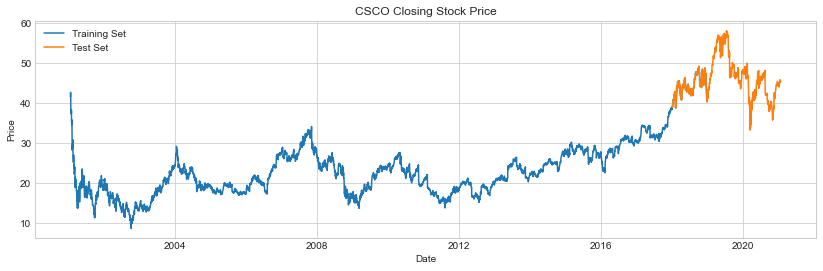

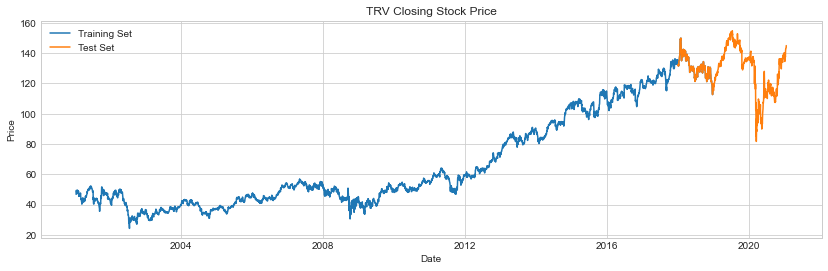

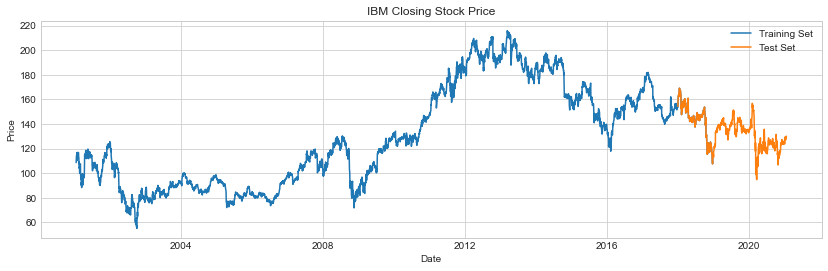

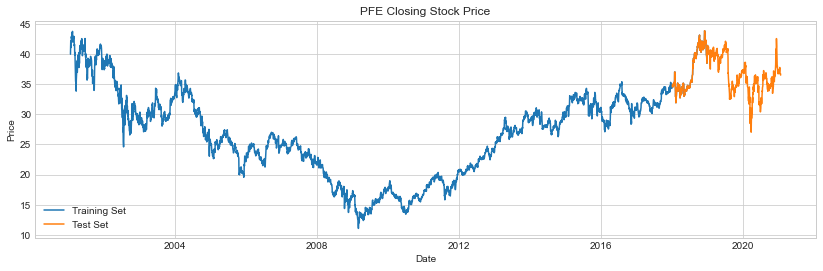

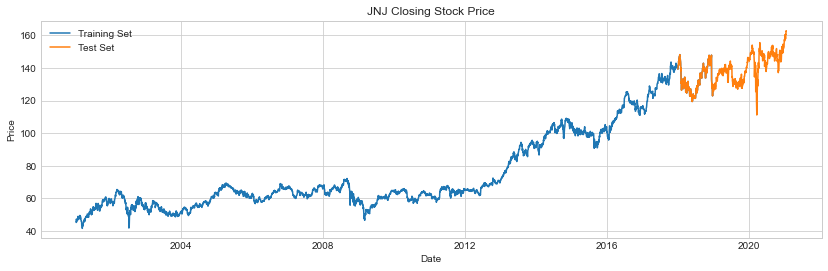

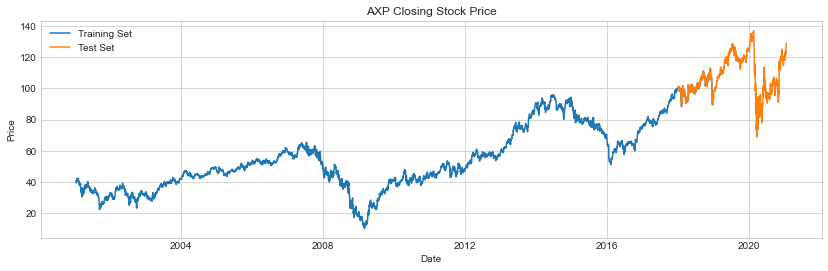

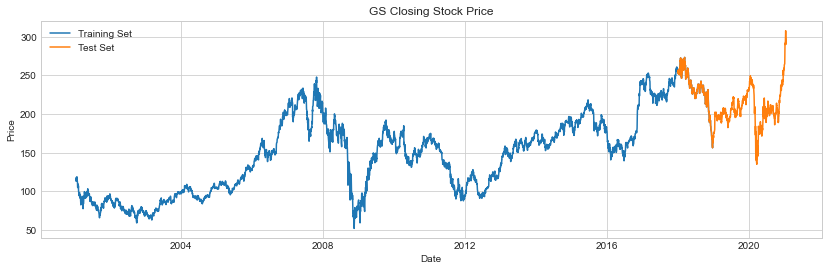

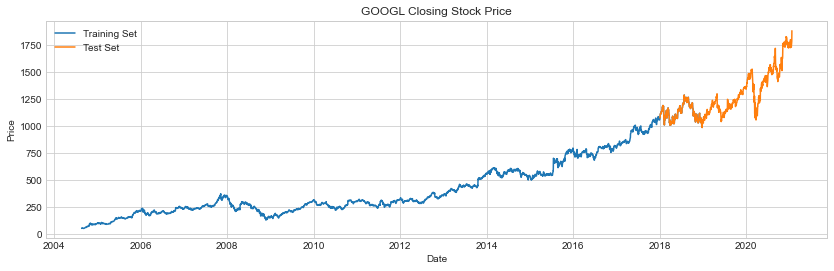

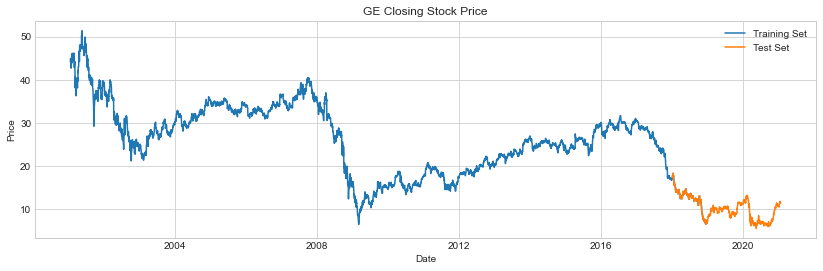

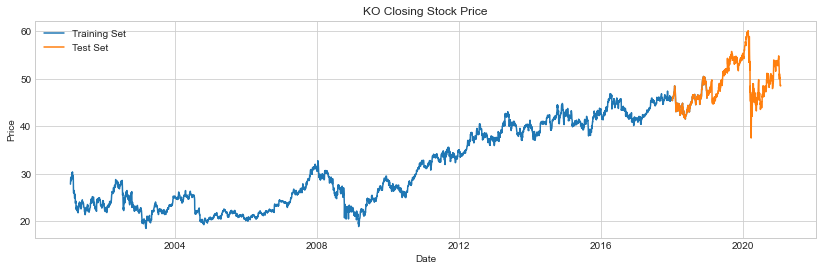

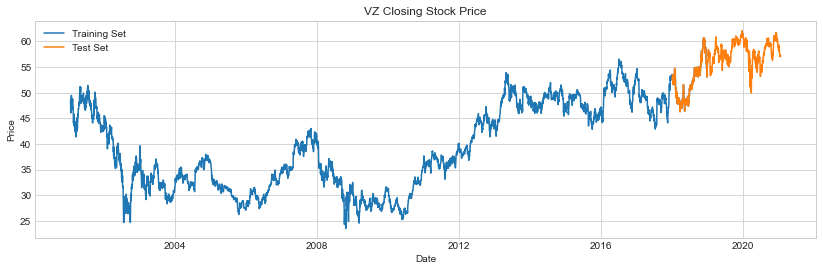

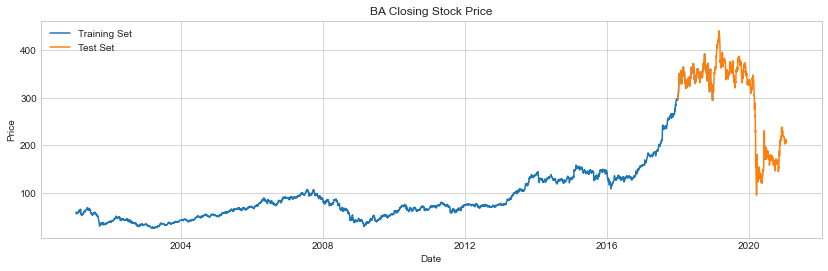

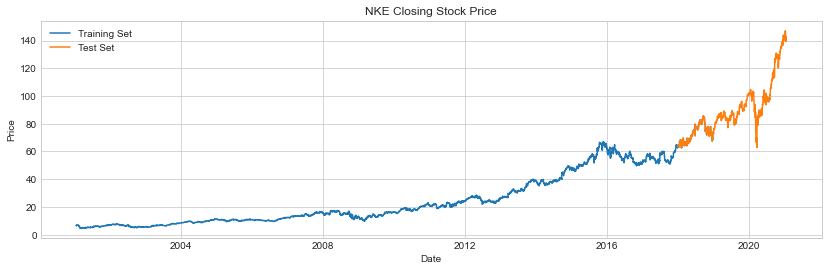

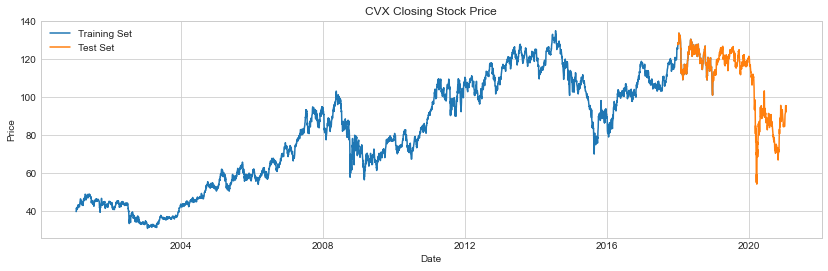

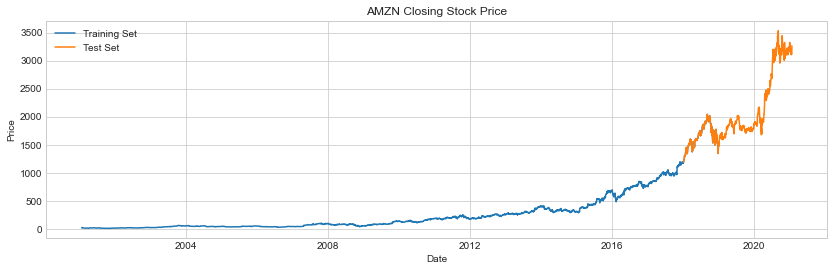

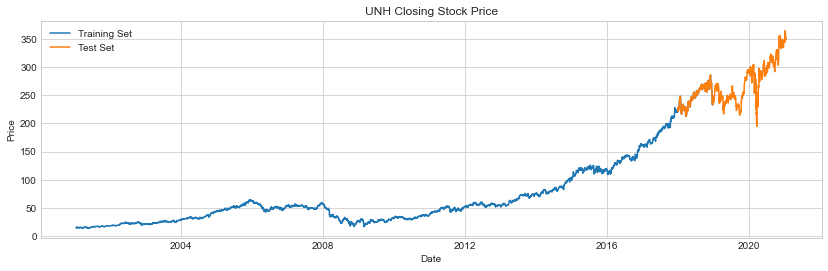

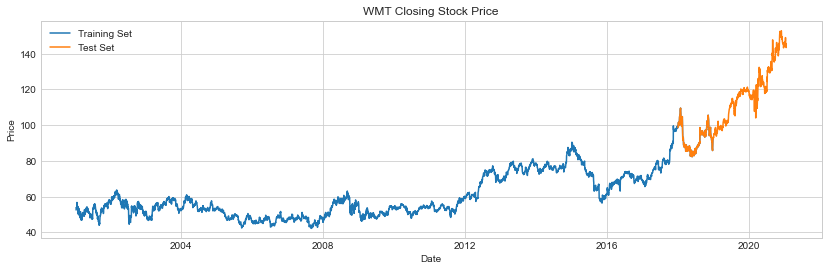

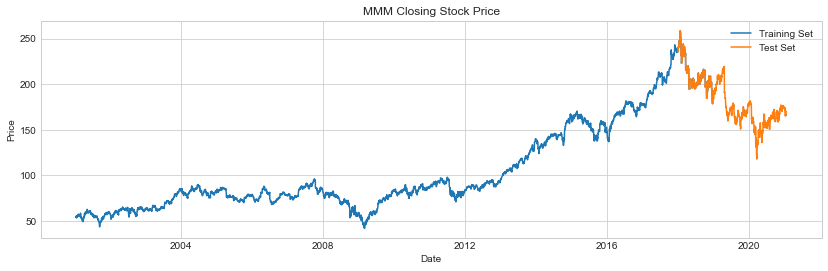

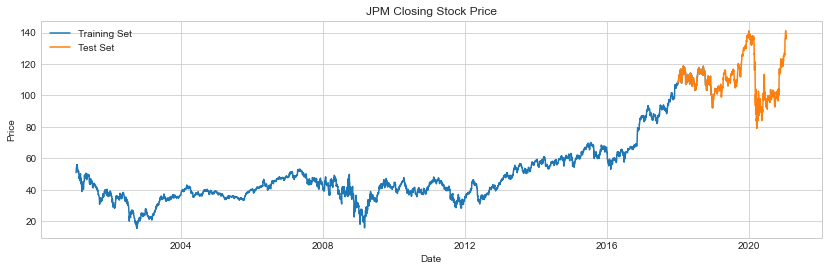

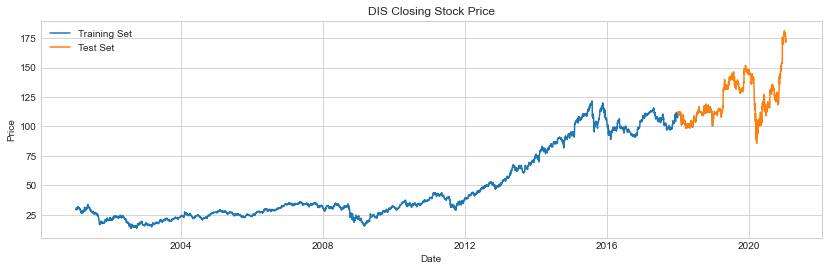

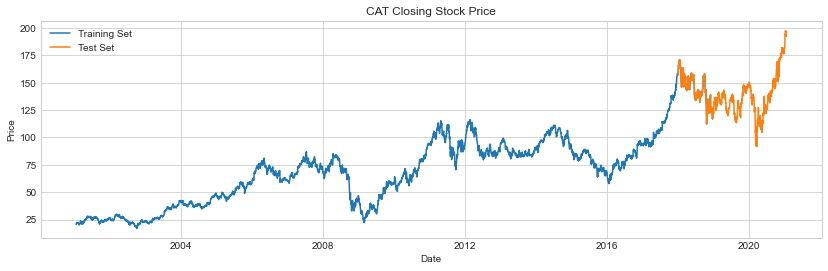

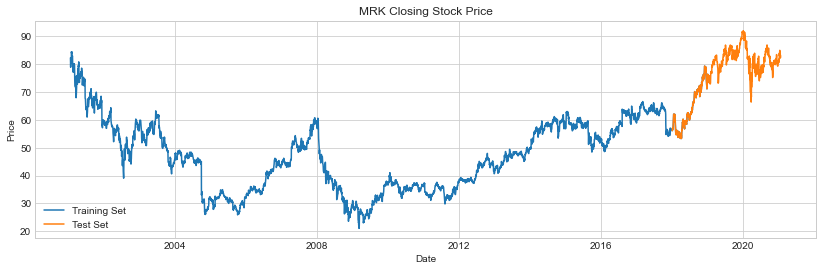

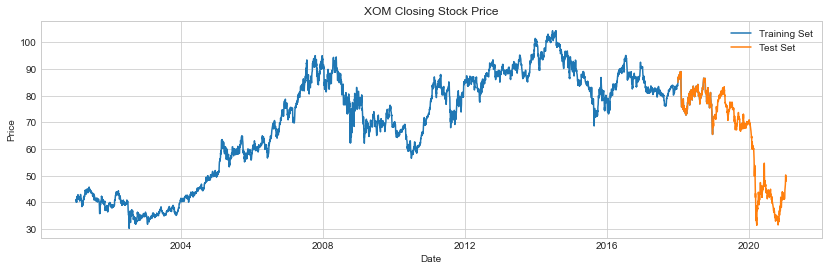

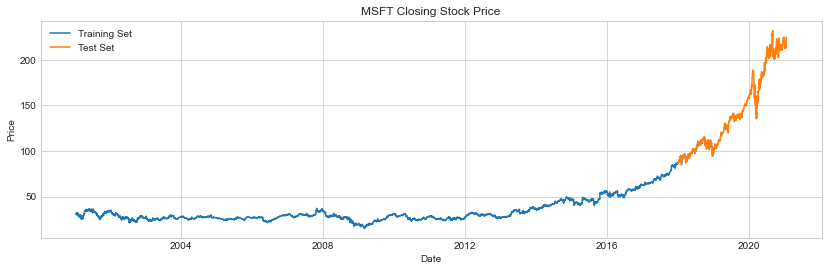

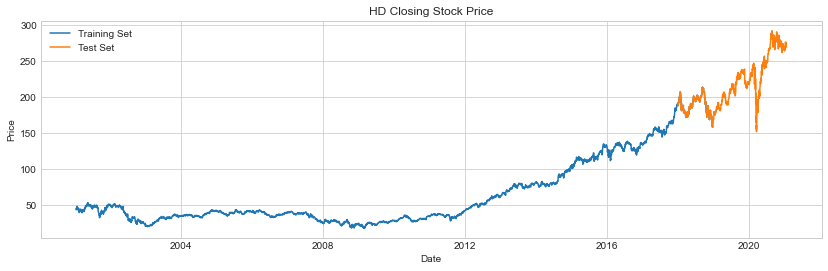

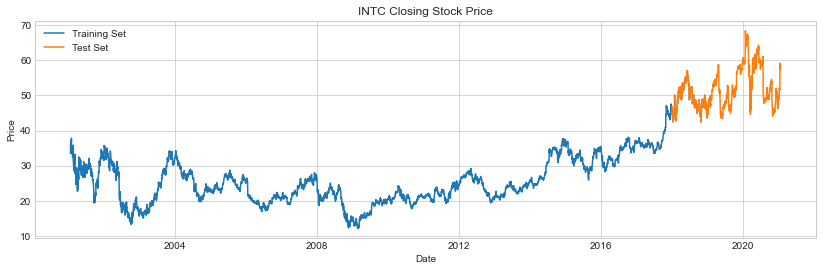

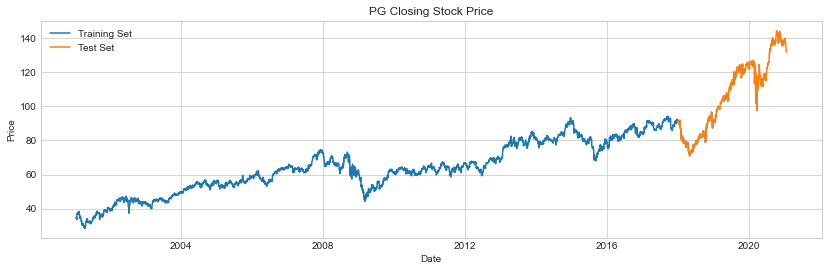

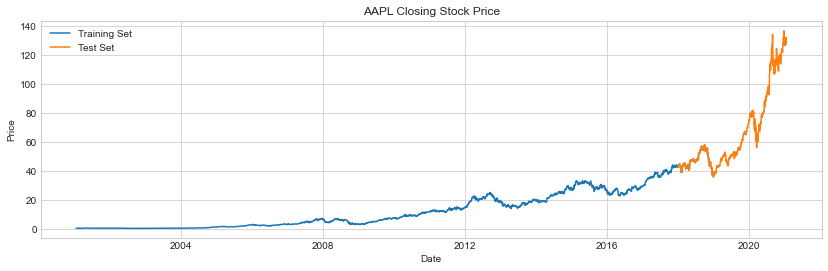

In [78]:
for stock in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_split_[stock]["Train"])
    plt.plot(df_split_[stock]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(stock + " Closing Stock Price")

We rescale all stock price to zero for the lowest and 1 for the highest. Each of company have their own scale. We make another two dictionary which contain scaled price for each company. One contain train set and another contain test set. 

We also create another dictionary for collecting the scaller. This will be useful when we want to inverse transform our prediction.

In [79]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_split_[i]["Train"])
    a1 = np.array(df_split_[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

We print the shape of our transformed set. Few company have the more than the other. This over value should be removed so the input will be uniform in term of shape

In [80]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

CSCO (4514, 1)
TRV (4514, 1)
IBM (4514, 1)
PFE (4514, 1)
JNJ (4514, 1)
AXP (4514, 1)
GS (4514, 1)
GOOGL (3617, 1)
GE (4514, 1)
KO (4514, 1)
VZ (4514, 1)
BA (4514, 1)
NKE (4514, 1)
CVX (4514, 1)
AMZN (4514, 1)
UNH (4514, 1)
WMT (4514, 1)
MMM (4514, 1)
JPM (4514, 1)
DIS (4514, 1)
CAT (4514, 1)
MRK (4514, 1)
XOM (4514, 1)
MSFT (4514, 1)
HD (4514, 1)
INTC (4514, 1)
PG (4514, 1)
AAPL (4514, 1)


CSCO (768, 1)
TRV (768, 1)
IBM (768, 1)
PFE (768, 1)
JNJ (768, 1)
AXP (768, 1)
GS (768, 1)
GOOGL (768, 1)
GE (768, 1)
KO (768, 1)
VZ (768, 1)
BA (768, 1)
NKE (768, 1)
CVX (768, 1)
AMZN (768, 1)
UNH (768, 1)
WMT (768, 1)
MMM (768, 1)
JPM (768, 1)
DIS (768, 1)
CAT (768, 1)
MRK (768, 1)
XOM (768, 1)
MSFT (768, 1)
HD (768, 1)
INTC (768, 1)
PG (768, 1)
AAPL (768, 1)


We think 60 feature will be enough training.   We prepare shape our test and train set for neural network input

In [103]:
trainset = {}
testset = {}

# build a three dimensional matrix for the train, and test set for each stock.
for stock in stockList:
    trainset[stock] = {}
    X_train = []
    y_train = []
    train_len = len(df_split_[stock]["Train"])
    for i in range(60,train_len):
        X_train.append(transform_train[stock][i-60:i,0])
        y_train.append(transform_train[stock][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[stock]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[stock]["y"] = y_train
    
    testset[stock] = {}
    X_test = []
    y_test = []   
    test_len = len(df_split_[stock]["Test"])
    for i in range(60, test_len):
        X_test.append(transform_test[stock][i-60:i,0])
        y_test.append(transform_test[stock][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[stock]["X"] = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    testset[stock]["y"] = y_test

Check the shape (again) before start training

In [104]:
arr_buff = []
for stock in stockList:
    buff = {}
    buff["X_train"] = trainset[stock]["X"].shape
    buff["y_train"] = trainset[stock]["y"].shape
    buff["X_test"] = testset[stock]["X"].shape
    buff["y_test"] = testset[stock]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

X_train  y_train        X_test  y_test
Ticker Symbol                                              
CSCO           (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
TRV            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
IBM            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
PFE            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
JNJ            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
AXP            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
GS             (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
GOOGL          (3557, 60, 1)  (3557,)  (708, 60, 1)  (708,)
GE             (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
KO             (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
VZ             (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
BA             (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
NKE            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
CVX            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
AMZN           (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
UNH            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
WMT            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
MMM            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
JPM            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
DIS            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
CAT            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
MRK            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
XOM            (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
MSFT           (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
HD             (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
INTC           (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
PG             (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)
AAPL           (4454, 60, 1)  (4454,)  (708, 60, 1)  (708,)

In [53]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=128, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=128, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=128))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for stock in stockList:
    print("Fitting to", stock)
    regressor.fit(trainset[stock]["X"], trainset[stock]["y"], epochs=10, batch_size=200)

Fitting to CSCO
Epoch 1/10
23/23 [==============================] - 16s 460ms/step - loss: 0.0666
Epoch 2/10
23/23 [==============================] - 15s 673ms/step - loss: 0.0142
Epoch 3/10
23/23 [==============================] - 22s 949ms/step - loss: 0.0101
Epoch 4/10
23/23 [==============================] - 24s 1s/step - loss: 0.0086
Epoch 5/10
23/23 [==============================] - 25s 1s/step - loss: 0.0078
Epoch 6/10
23/23 [==============================] - 25s 1s/step - loss: 0.0077
Epoch 7/10
23/23 [==============================] - 25s 1s/step - loss: 0.0068
Epoch 8/10
23/23 [==============================] - 28s 1s/step - loss: 0.0056
Epoch 9/10
23/23 [==============================] - 26s 1s/step - loss: 0.0057
Epoch 10/10
23/23 [==============================] - 26s 1s/step - loss: 0.0054
Fitting to TRV
Epoch 1/10
23/23 [==============================] - 25s 1s/step - loss: 0.0051
Epoch 2/10
23/23 [==============================] - 25s 1s/step - loss: 0.0046
Epoch 3/10


23/23 [==============================] - 24s 1s/step - loss: 9.6301e-04
Epoch 3/10
23/23 [==============================] - 24s 1s/step - loss: 9.8183e-04
Epoch 4/10
23/23 [==============================] - 24s 1s/step - loss: 8.6750e-04
Epoch 5/10
23/23 [==============================] - 24s 1s/step - loss: 9.1849e-04
Epoch 6/10
23/23 [==============================] - 25s 1s/step - loss: 9.6207e-04
Epoch 7/10
23/23 [==============================] - 27s 1s/step - loss: 9.0597e-04
Epoch 8/10
23/23 [==============================] - 27s 1s/step - loss: 9.8376e-04
Epoch 9/10
23/23 [==============================] - 27s 1s/step - loss: 9.0111e-04
Epoch 10/10
23/23 [==============================] - 28s 1s/step - loss: 8.9311e-04
Fitting to MRK
Epoch 1/10
23/23 [==============================] - 25s 1s/step - loss: 0.0012
Epoch 2/10
23/23 [==============================] - 24s 1s/step - loss: 0.0011
Epoch 3/10
23/23 [==============================] - 24s 1s/step - loss: 0.0011
Epoch 4/10


<ipython-input-83-84d8c01b9af4>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14,6))


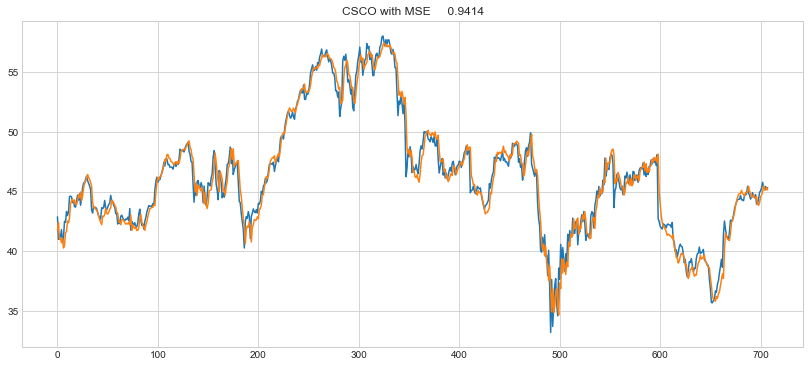

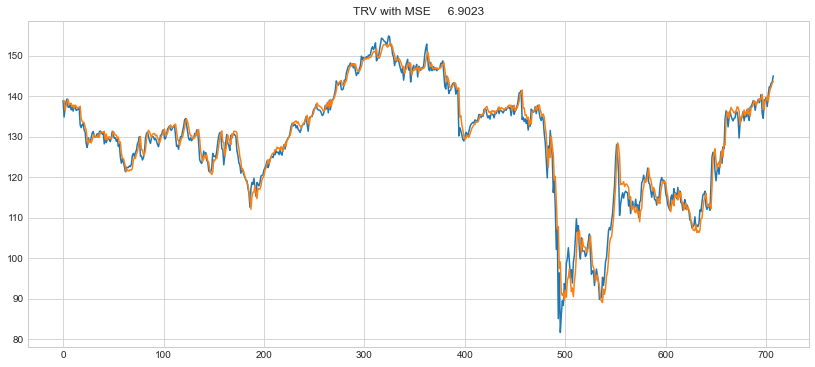

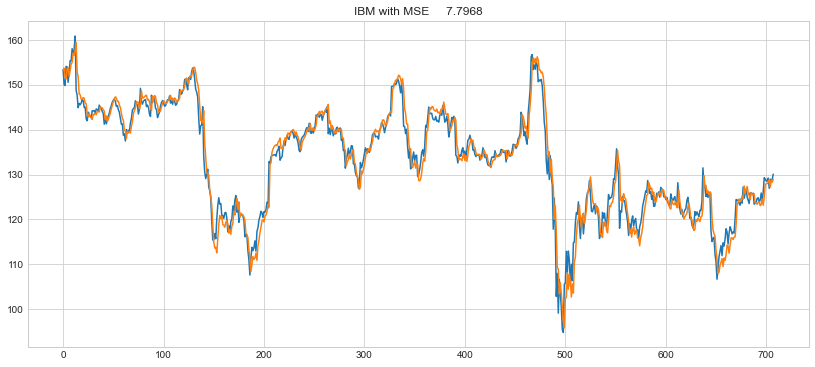

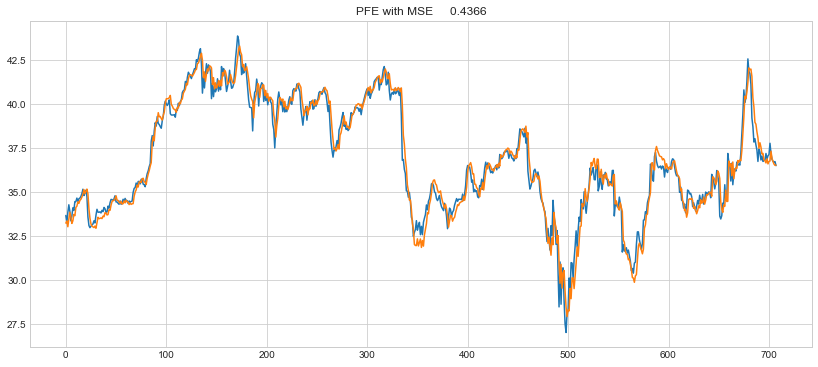

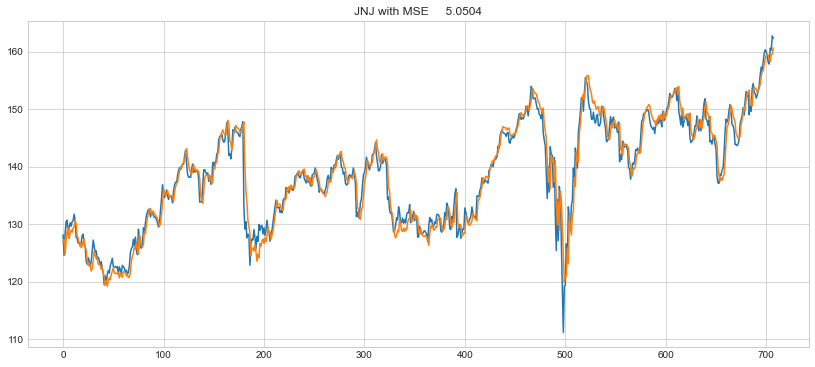

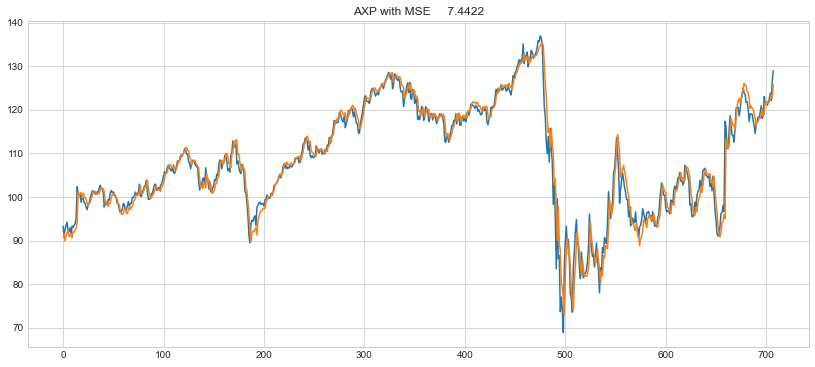

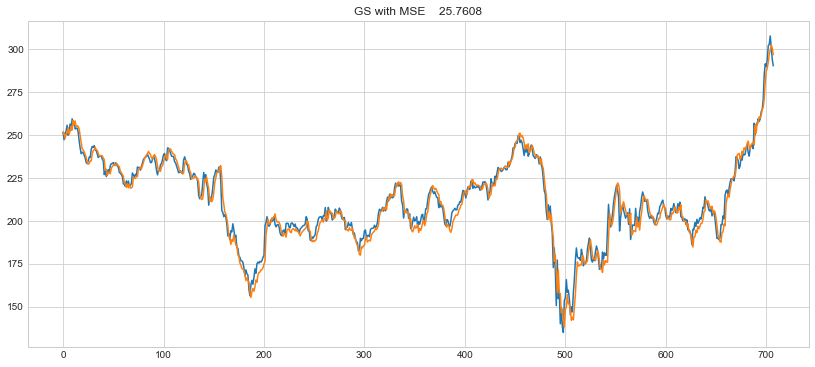

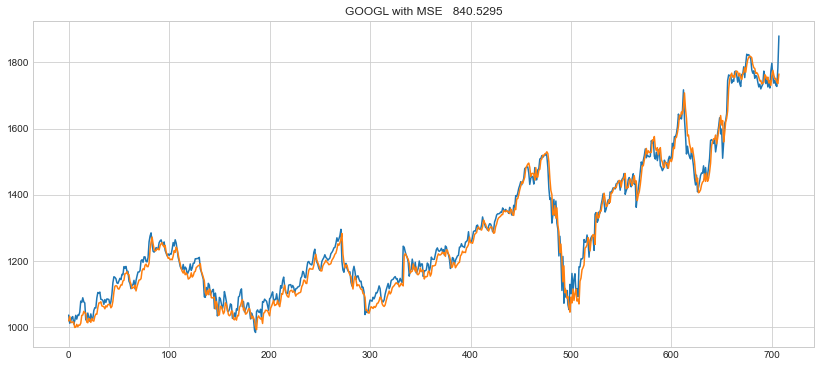

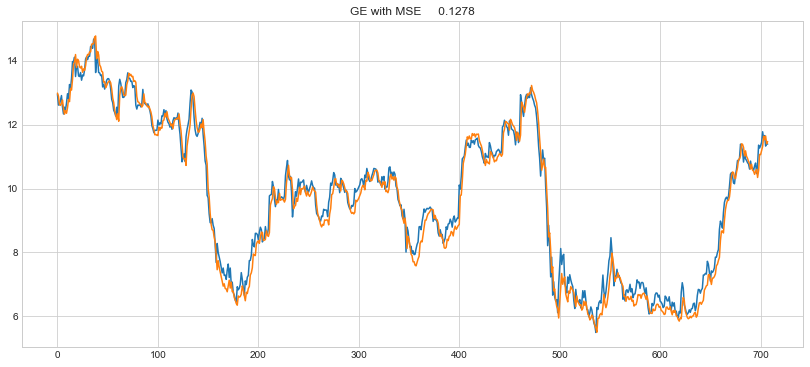

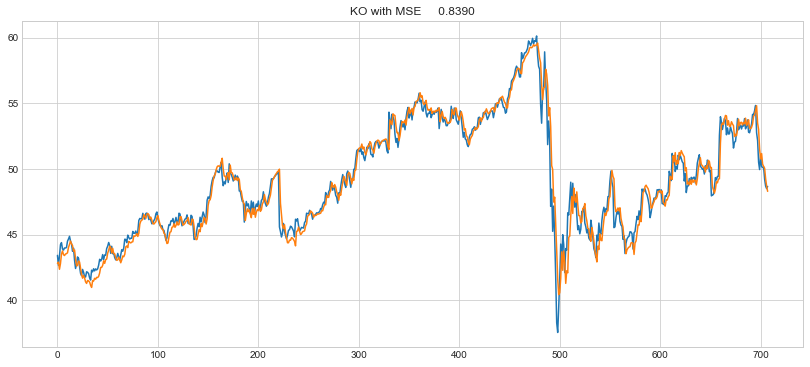

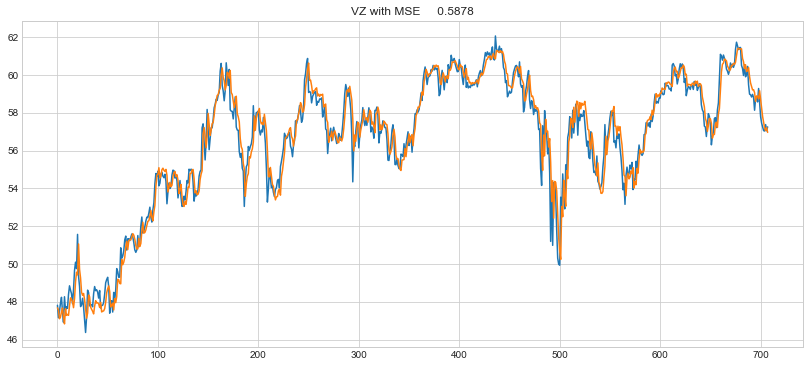

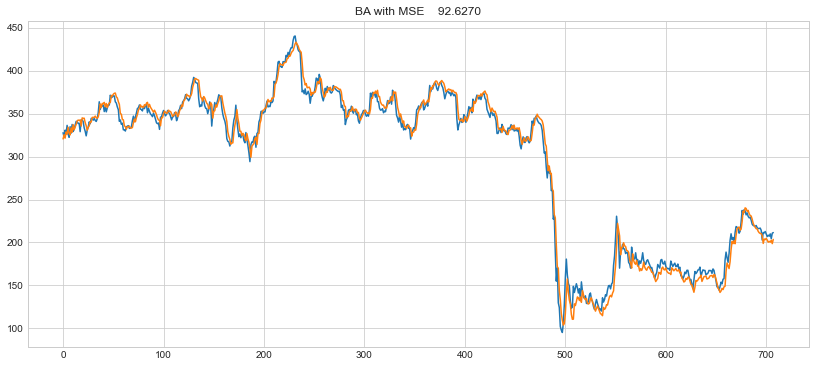

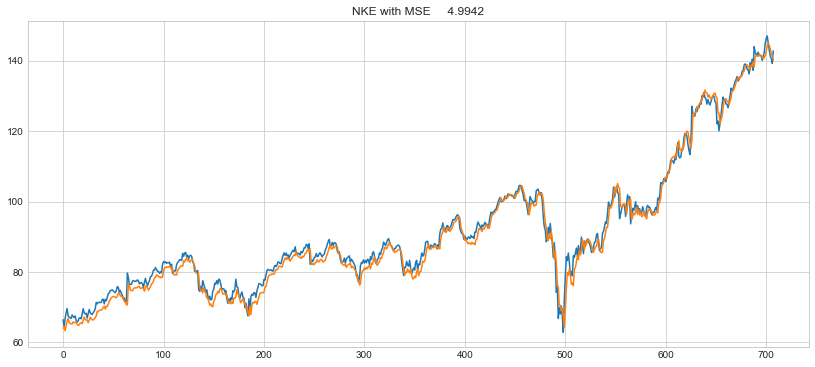

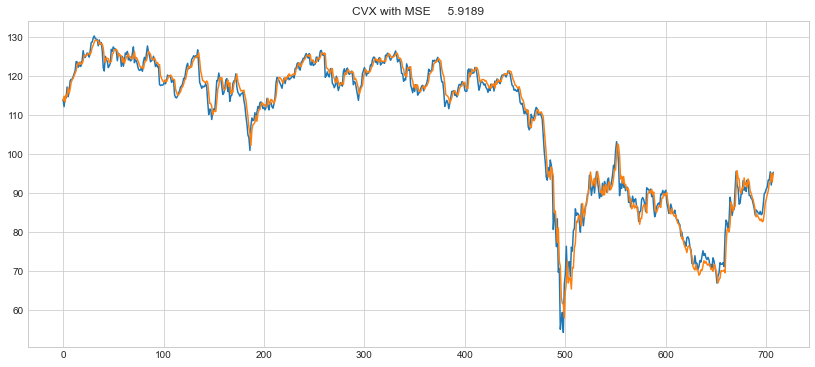

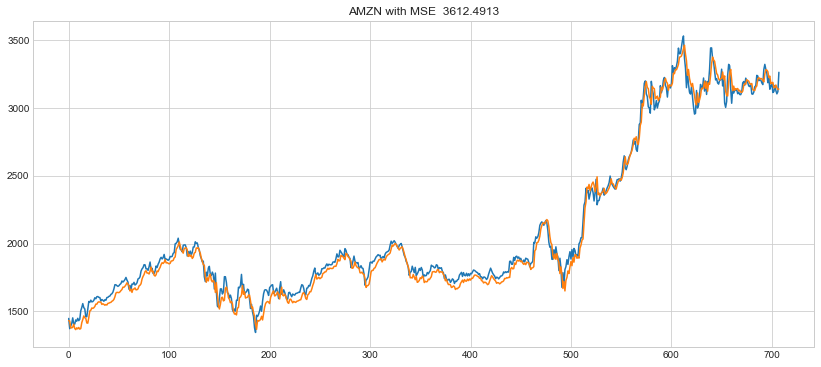

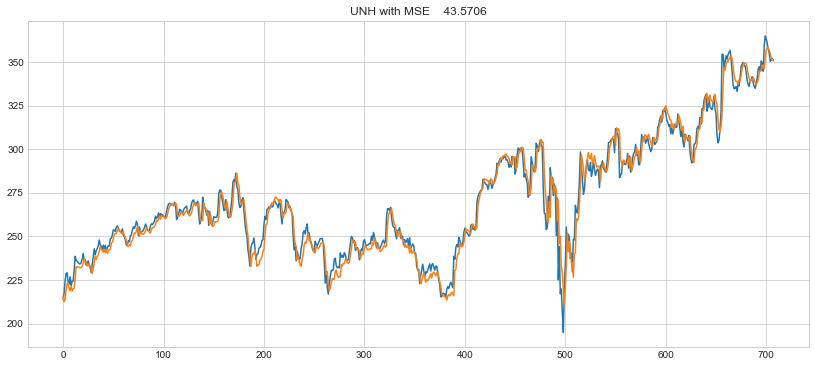

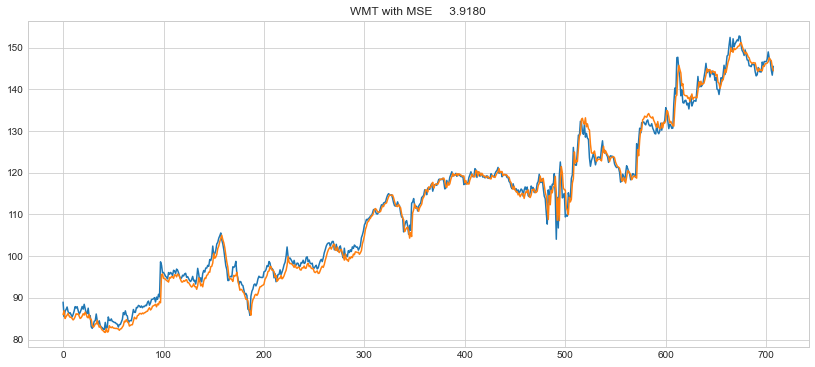

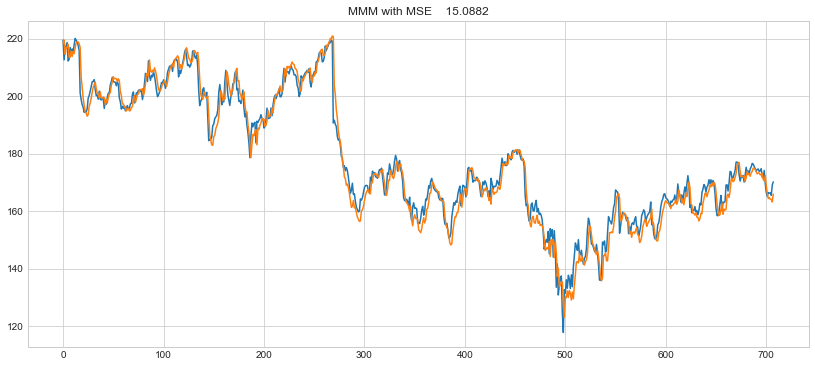

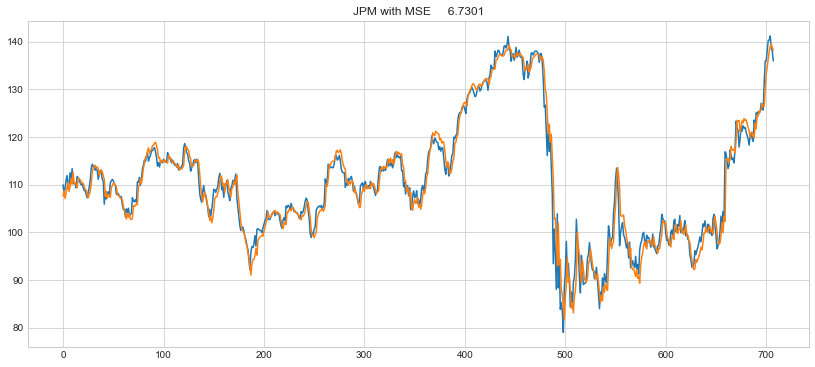

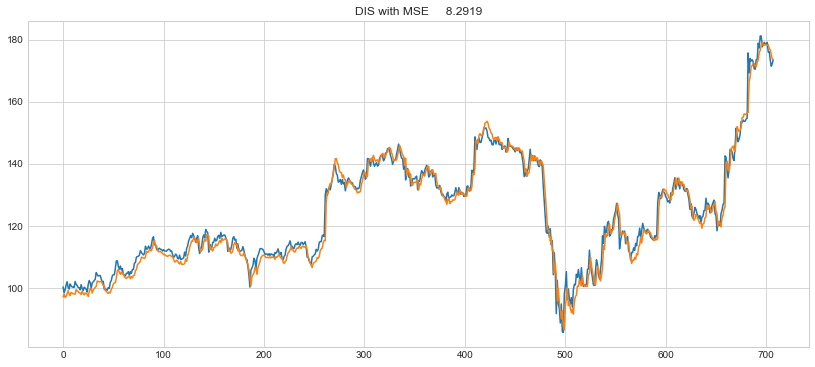

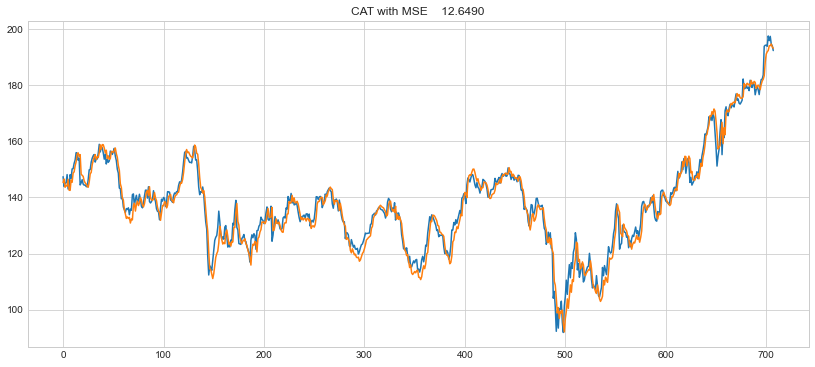

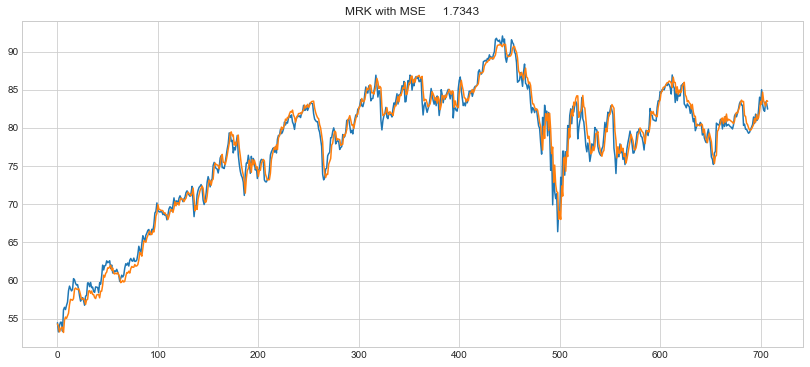

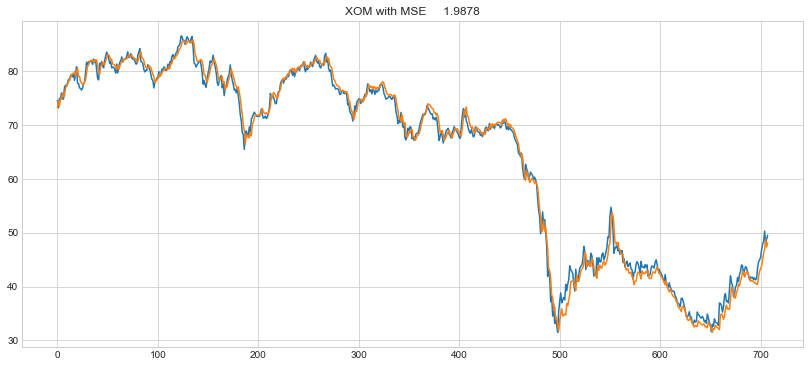

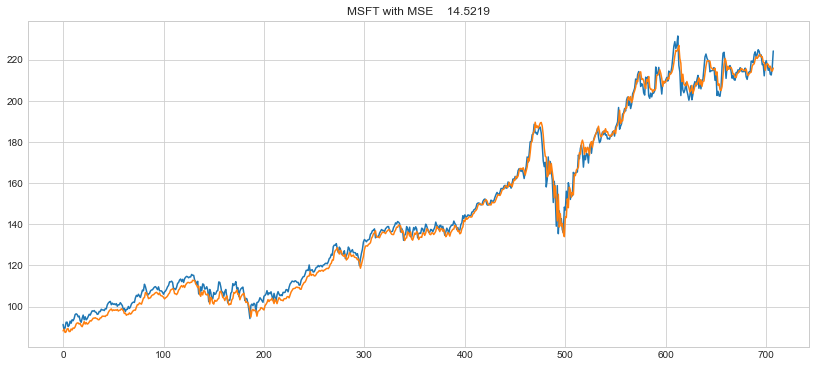

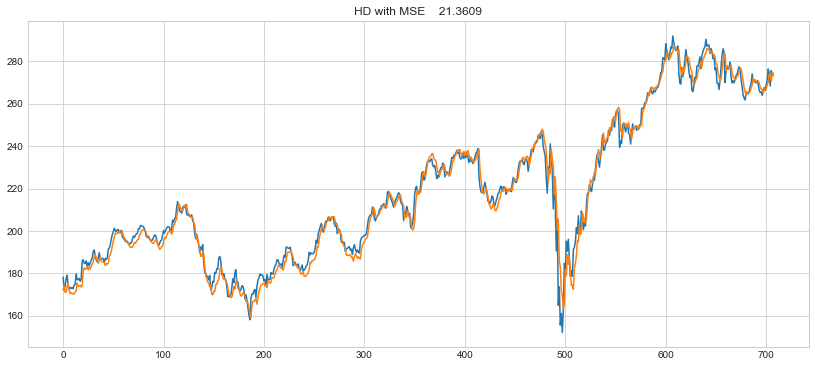

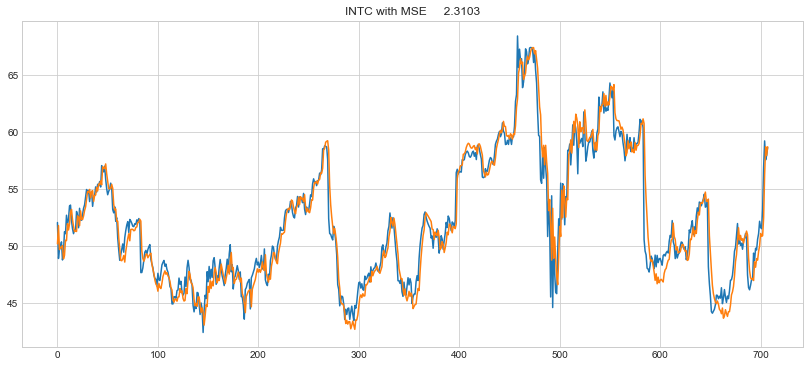

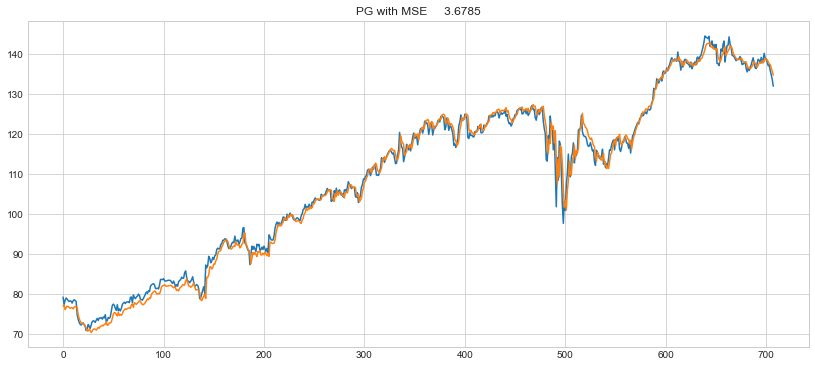

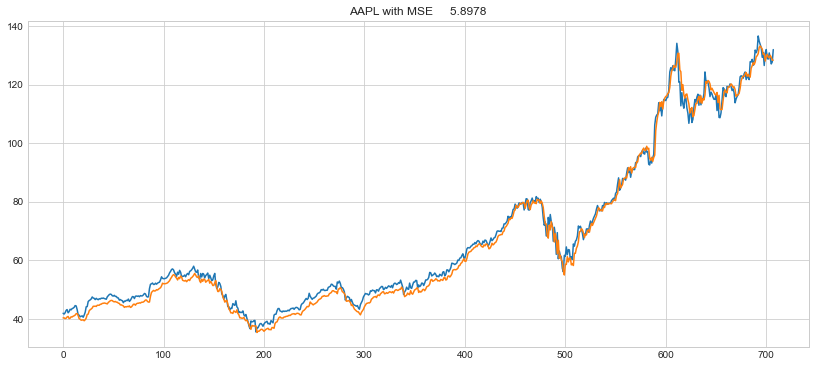

In [83]:
pred_result = {}
for stock in stockList:
    y_true = scaler[stock].inverse_transform(testset[stock]["y"].reshape(-1,1))
    y_pred = scaler[stock].inverse_transform(regressor.predict(testset[stock]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    #print(y_true)
    pred_result[stock] = {}
    pred_result[stock]["True"] = y_true
    pred_result[stock]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(stock,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

We can improve our prediction by introducing shifting/lagging. Essentialy we slide our prediction for a period of time. This is a common practice in signal processing subfield.

When we displace to make our prediction start earlier, we call it lagging. As for consequences, lagged prediction will have last -- equal to how much we displace the prediction -- value equal to NaN. If we lag it by 5 day, then the last 5 day prediction will become NaN. 

When we displace to make our prediction start later, we call it shifting. As for consequenceses, shifted prediction will have first -- equal to how much we displace the prediction -- value equal to NaN. If we shift it by 5 day, then the last 5 day prediction will become NaN.

In [84]:

def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    return df_true, df_pred, df_pred_lag
    
   


In [139]:
#create dataset for the predictions
stockList = df_companyList['Ticker Symbol']

from datetime import date, timedelta

# Set up End and Start times for data grab
end = date.today()
start = date.today() - timedelta(365)


#For loop for grabing yahoo finance data and setting as a dataframe
for stock in stockList:   
    # Set DataFrame as the Stock Ticker
    #print(stock)
    df = DataReader(stock, 'yahoo', start, end)
    df["company_name"] = stock
    df.to_csv(f"input/{stock}_prediction.csv")
    
    
df_new = {}
for stock in stockList:
    df_new[stock] = pd.read_csv("input/" + stock + "_prediction.csv", index_col="Date", parse_dates=["Date"])



In [140]:
df_pred = {}
for stock in stockList:
    df_pred[stock] = {}
    df_pred[stock]["Pred"] = df_new[stock].loc[:,"Close"]

<ipython-input-141-a3c7a9713257>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14,4))


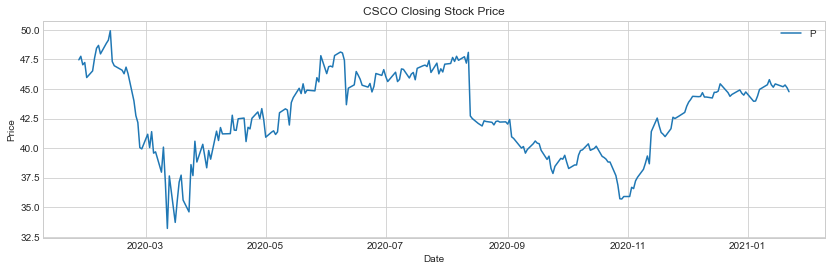

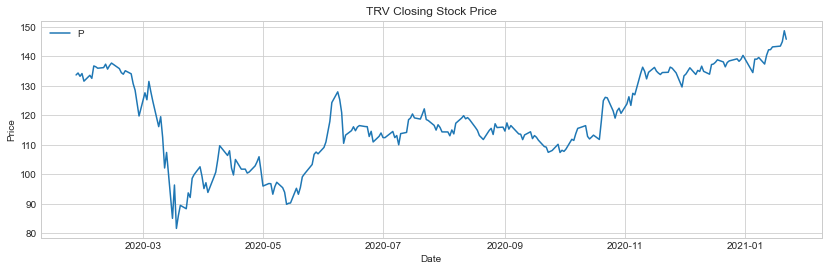

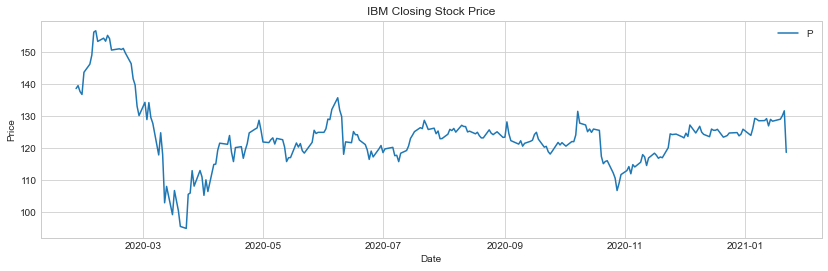

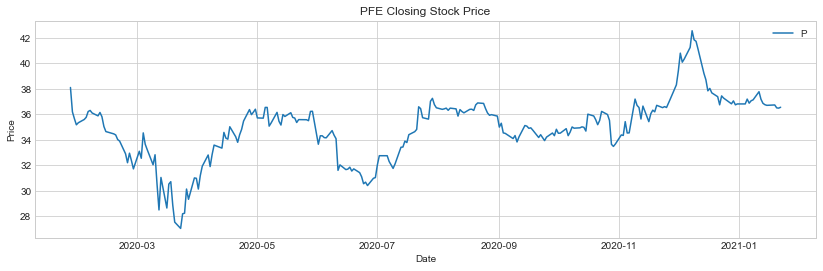

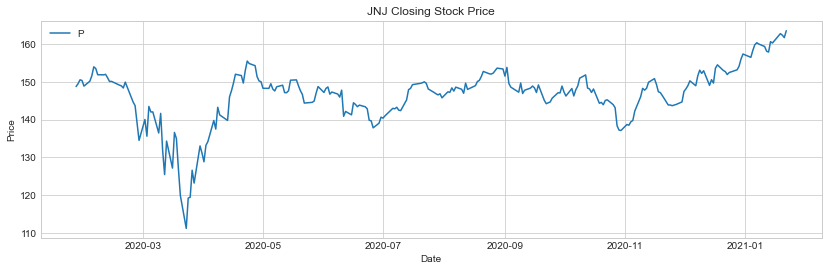

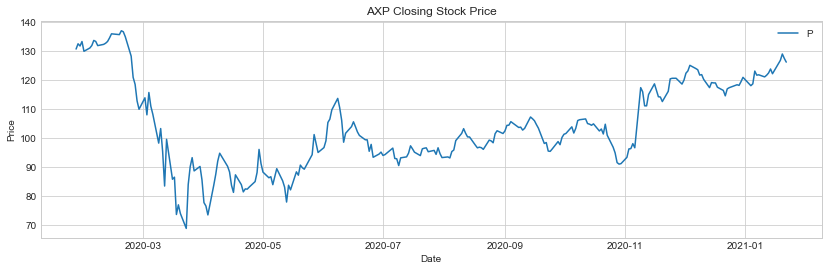

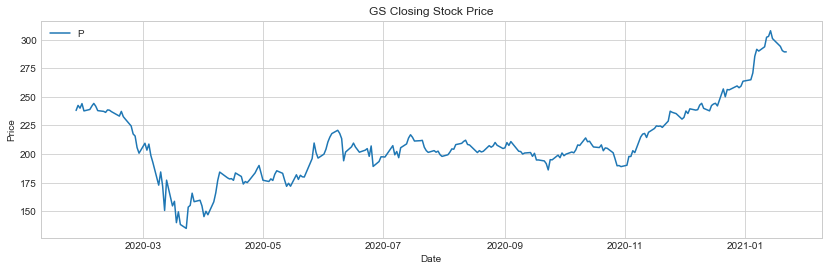

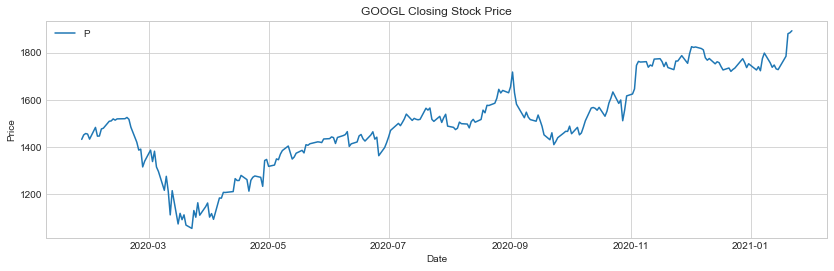

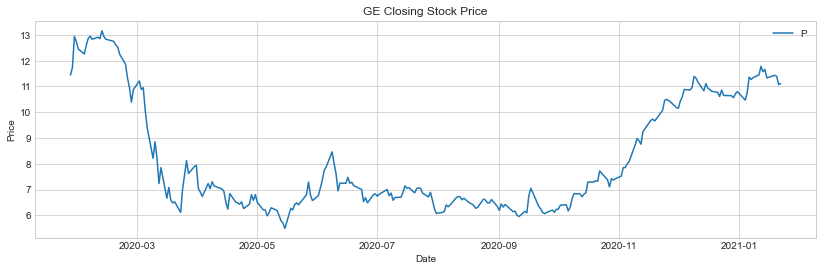

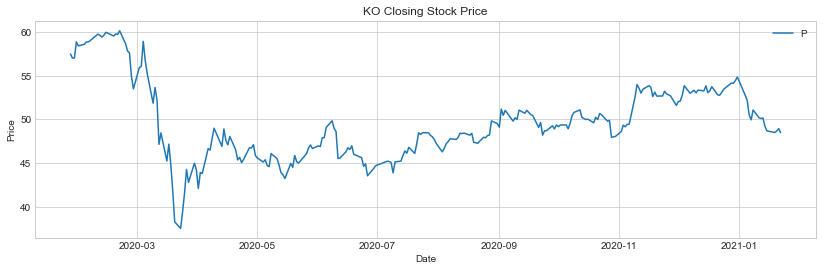

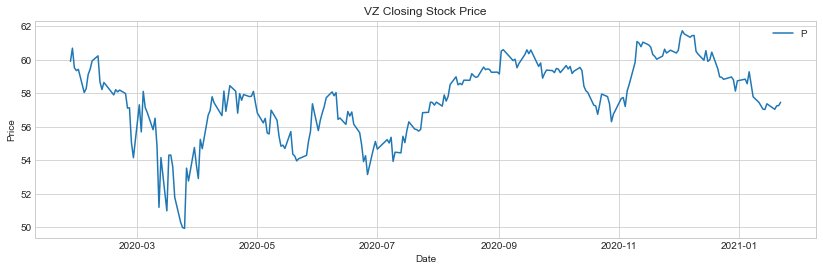

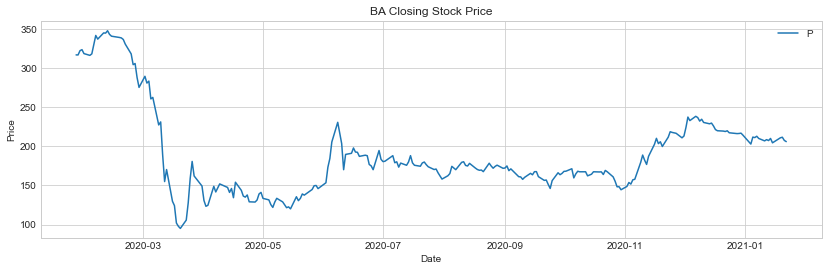

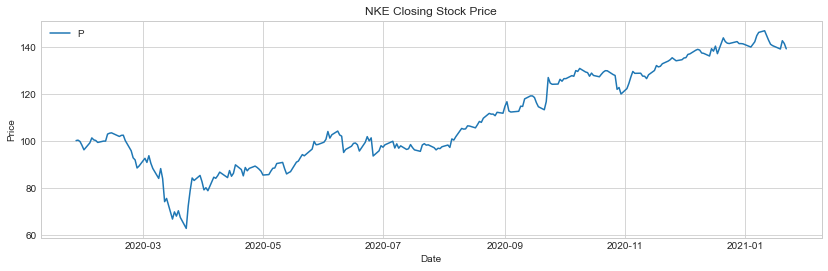

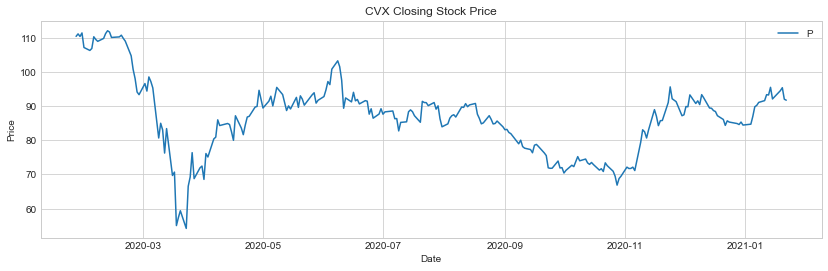

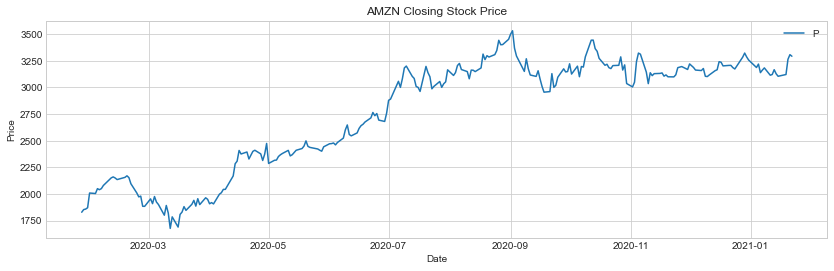

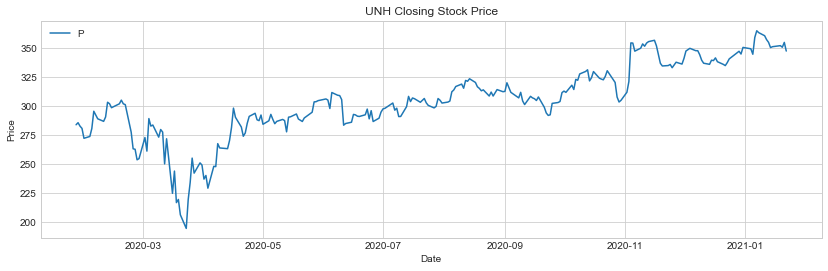

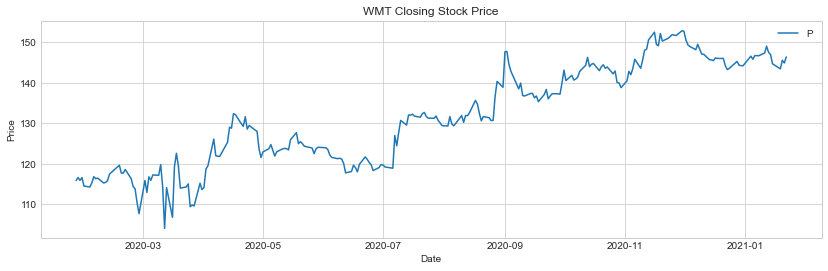

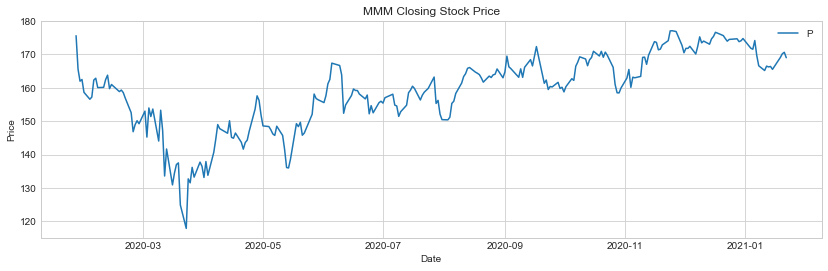

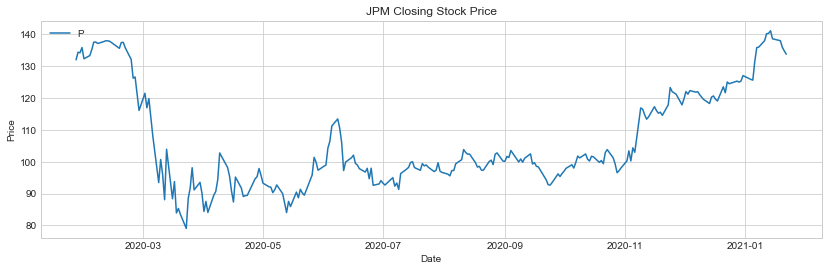

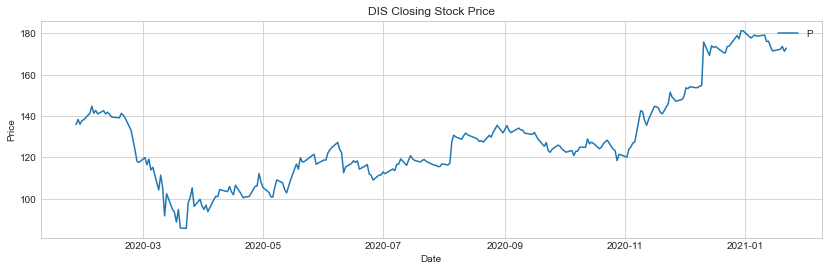

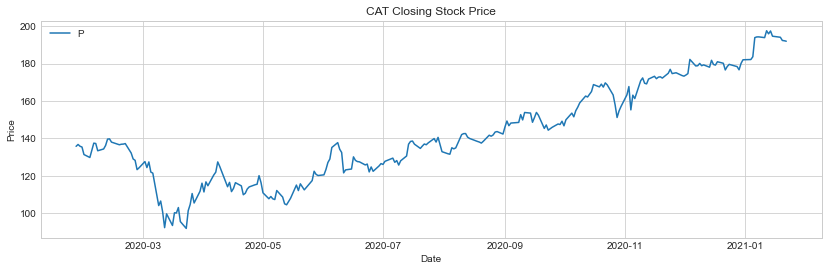

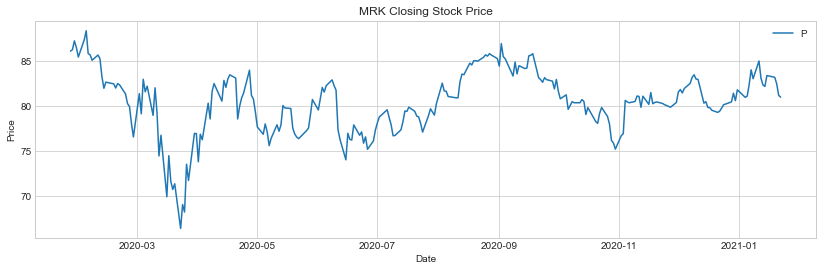

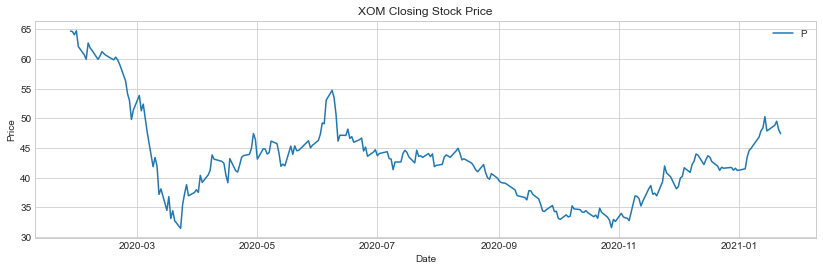

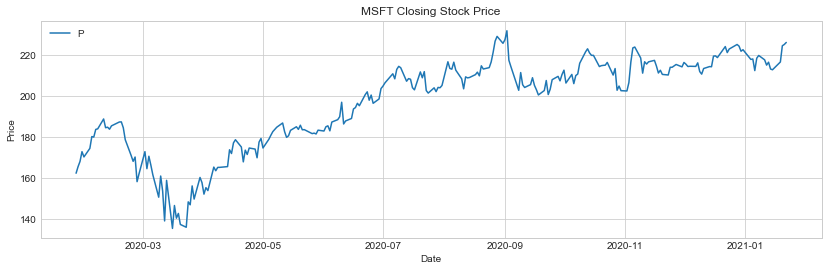

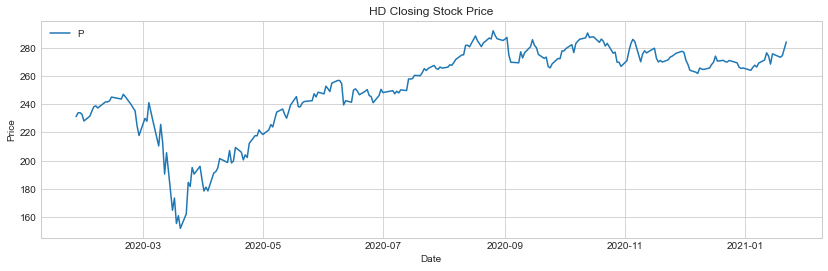

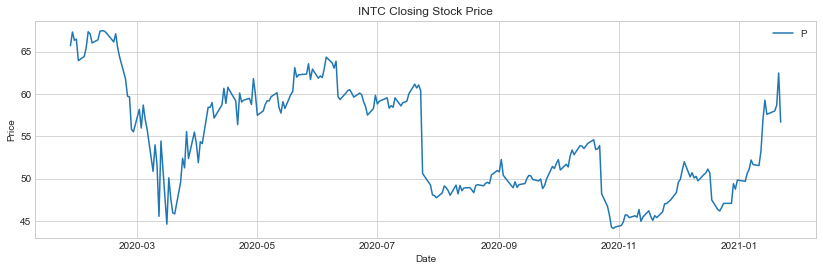

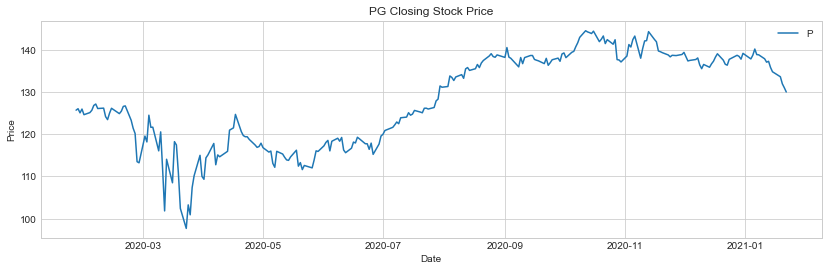

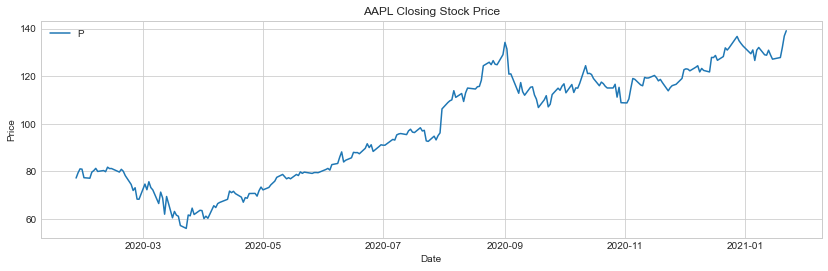

In [141]:
for stock in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_pred[stock]["Pred"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend("Pred Set")
    plt.title(stock + " Closing Stock Price")

In [143]:
#scale the predset
transform_pred = {}
scaler_pred = {}

for num, stock in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a2 = np.array(df_pred[stock]["Pred"])  
    a2 = a2.reshape(a2.shape[0],1)   
    transform_pred[stock] = sc.fit_transform(a2)
    print(transform_pred[stock].shape)

    scaler_pred[stock] = sc
    
del a2


(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)
(251, 1)


In [144]:
predset = {}
for stock in stockList:
    predset[stock] = {}
    X_pred = []
    y_pred = []   
    pred_len = len(df_pred[stock]['Pred'])
  
    for i in range(60, pred_len):
        X_pred.append(transform_pred[stock][i-60:i,0])
        y_pred.append(transform_pred[stock][i,0])
    X_pred, y_pred = np.array(X_pred), np.array(y_pred)
   # print(X_pred.shape)
    predset[stock]["X"] = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 1))
    predset[stock]["y"] = y_pred


In [145]:
arr_pred = []
for stock in stockList:
    buff = {}
    buff["X_pred"] = predset[stock]["X"].shape
    buff["y_pred"] = predset[stock]["y"].shape
    arr_pred.append(buff)

pd.DataFrame(arr_pred, index=stockList)

X_pred  y_pred
Ticker Symbol                      
CSCO           (191, 60, 1)  (191,)
TRV            (191, 60, 1)  (191,)
IBM            (191, 60, 1)  (191,)
PFE            (191, 60, 1)  (191,)
JNJ            (191, 60, 1)  (191,)
AXP            (191, 60, 1)  (191,)
GS             (191, 60, 1)  (191,)
GOOGL          (191, 60, 1)  (191,)
GE             (191, 60, 1)  (191,)
KO             (191, 60, 1)  (191,)
VZ             (191, 60, 1)  (191,)
BA             (191, 60, 1)  (191,)
NKE            (191, 60, 1)  (191,)
CVX            (191, 60, 1)  (191,)
AMZN           (191, 60, 1)  (191,)
UNH            (191, 60, 1)  (191,)
WMT            (191, 60, 1)  (191,)
MMM            (191, 60, 1)  (191,)
JPM            (191, 60, 1)  (191,)
DIS            (191, 60, 1)  (191,)
CAT            (191, 60, 1)  (191,)
MRK            (191, 60, 1)  (191,)
XOM            (191, 60, 1)  (191,)
MSFT           (191, 60, 1)  (191,)
HD             (191, 60, 1)  (191,)
INTC           (191, 60, 1)  (191,)
PG             (191, 60, 1)  (191,)
AAPL           (191, 60, 1)  (191,)

<ipython-input-146-d4dc90214401>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14,6))


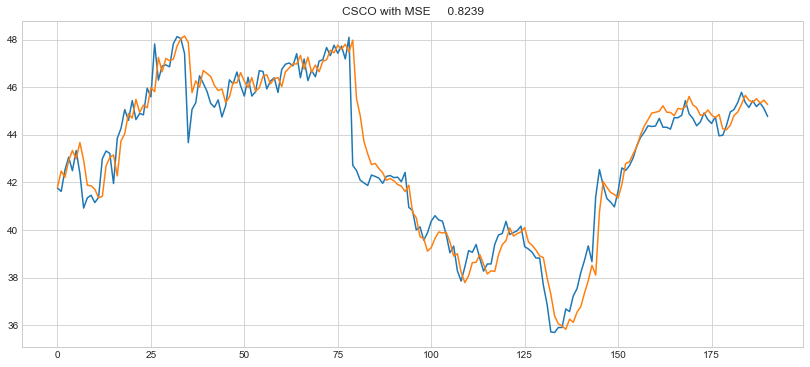

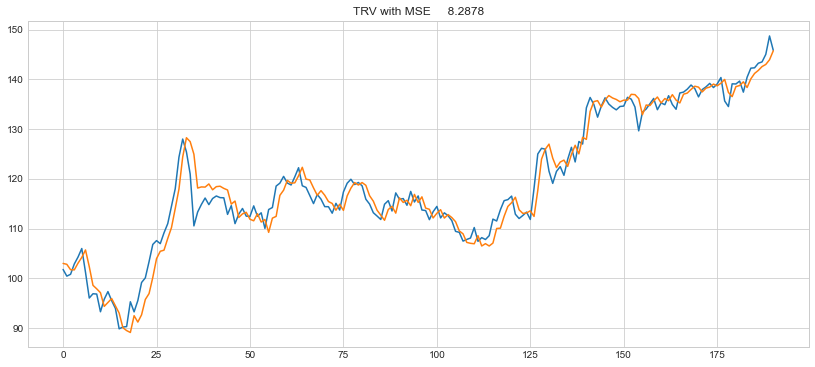

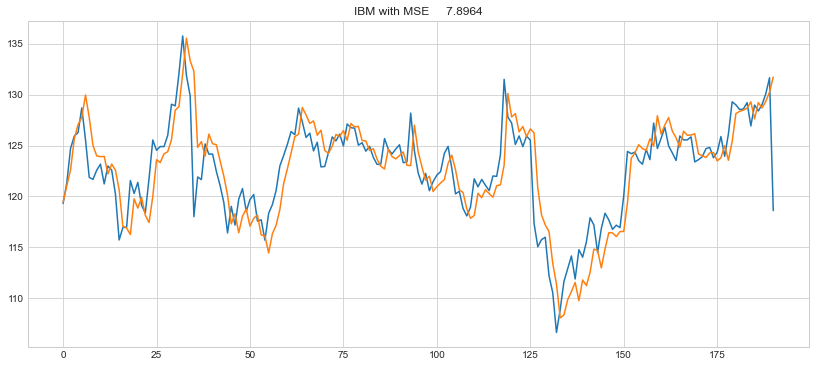

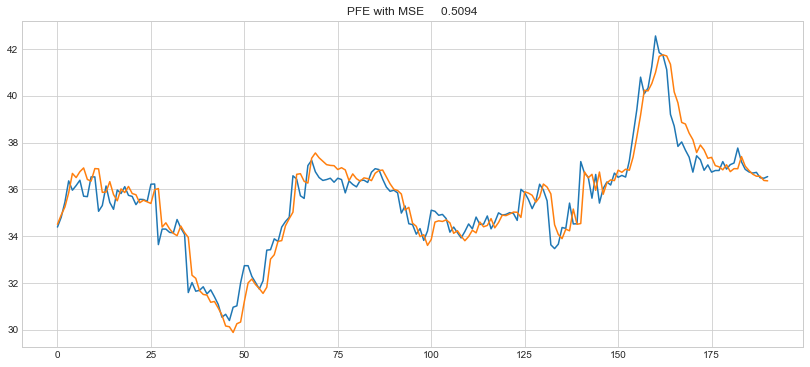

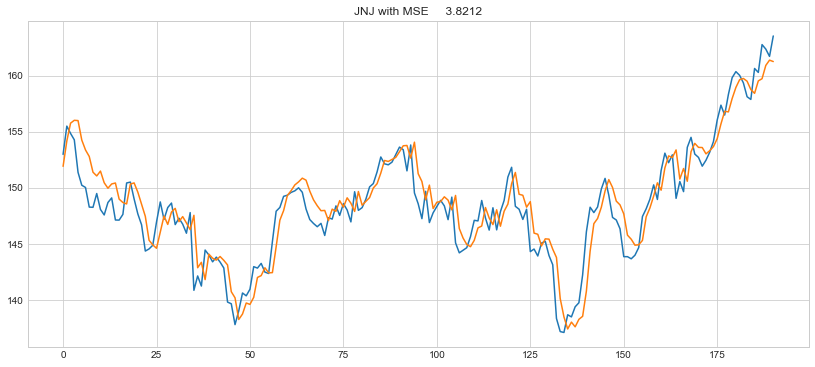

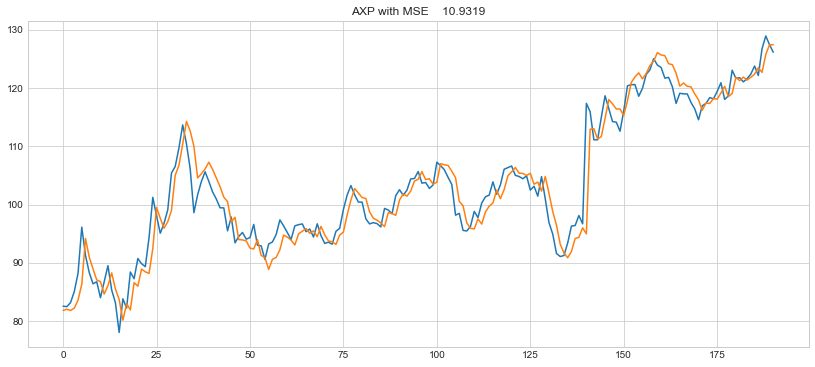

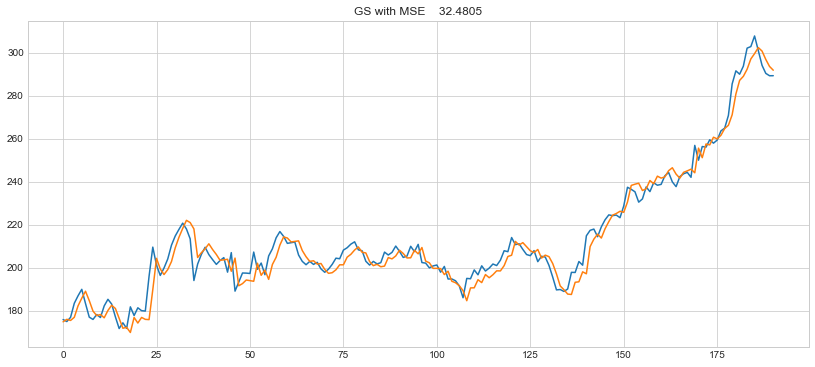

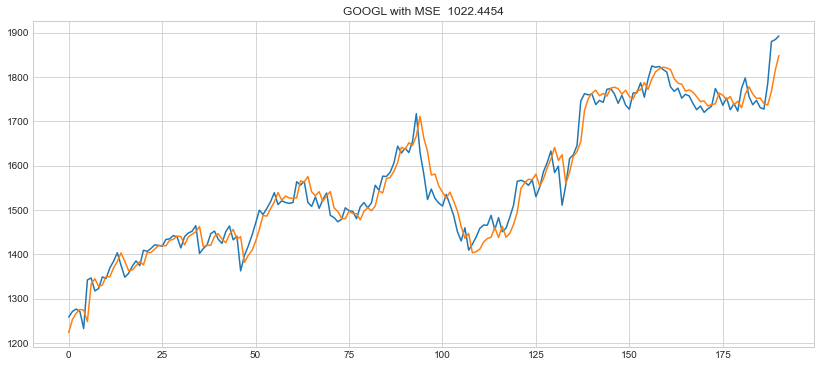

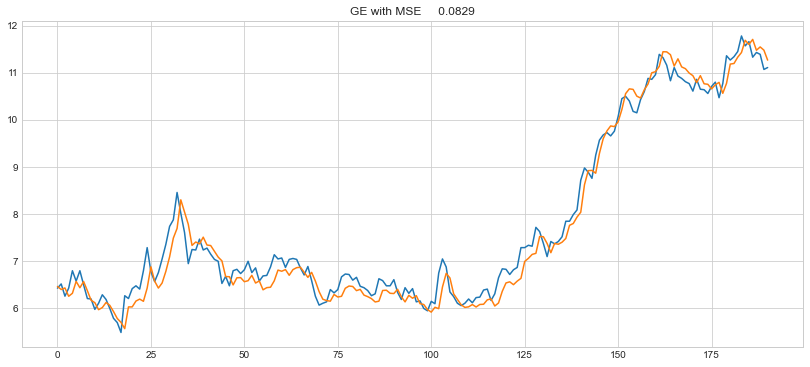

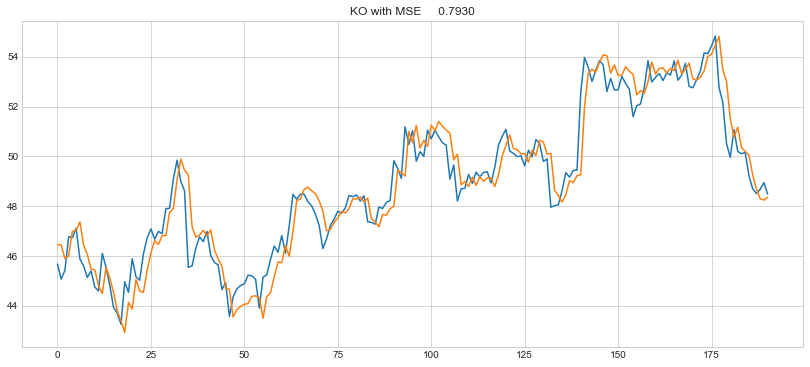

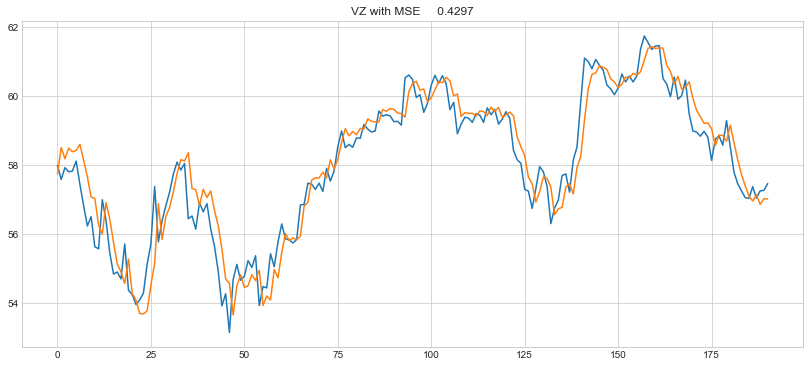

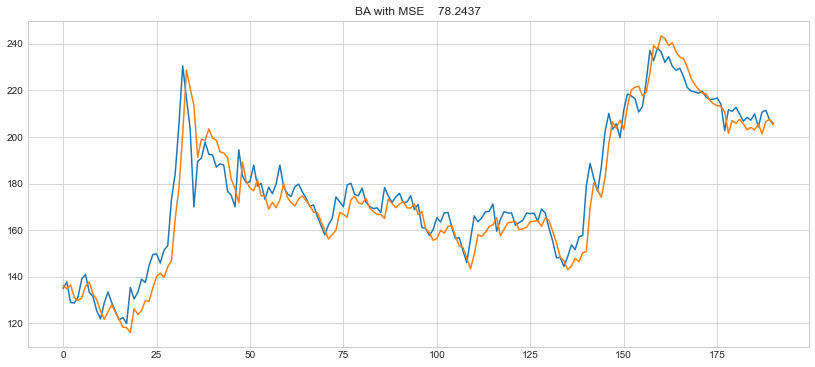

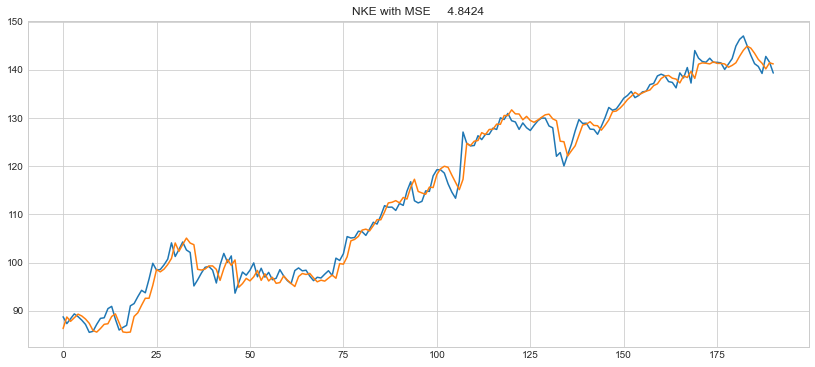

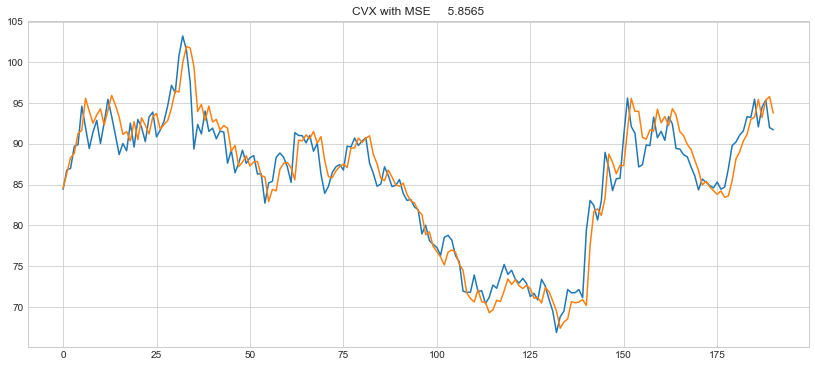

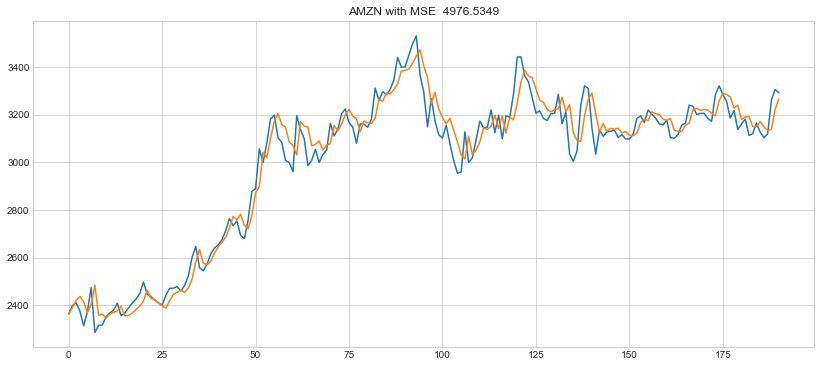

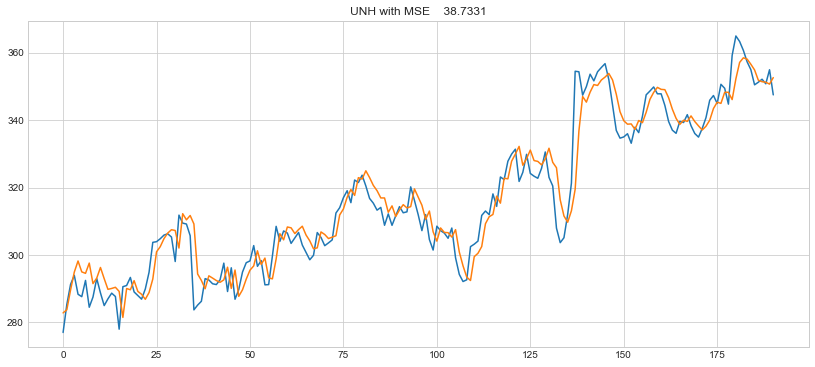

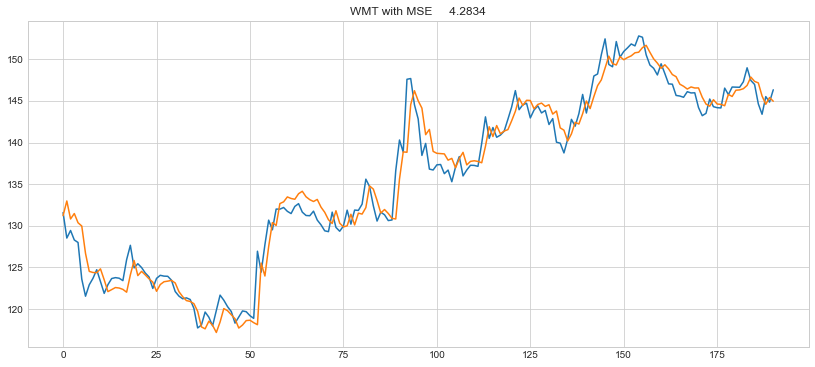

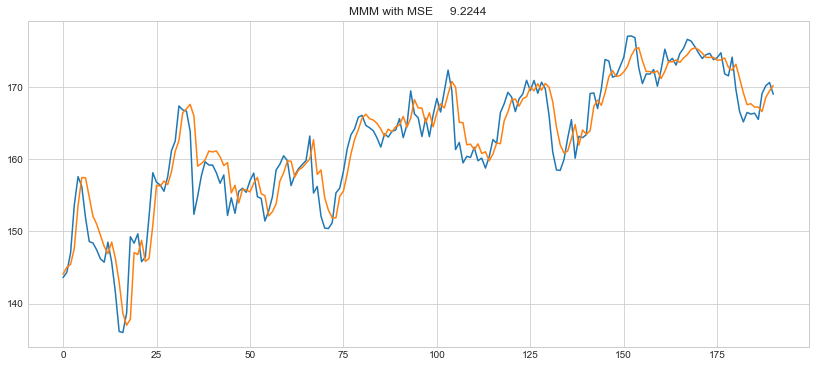

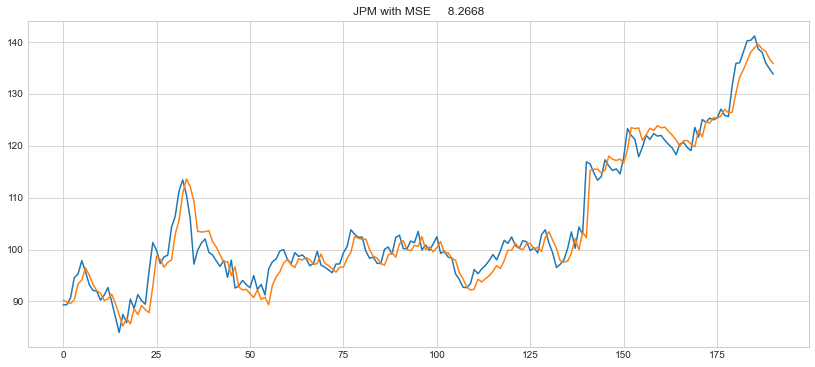

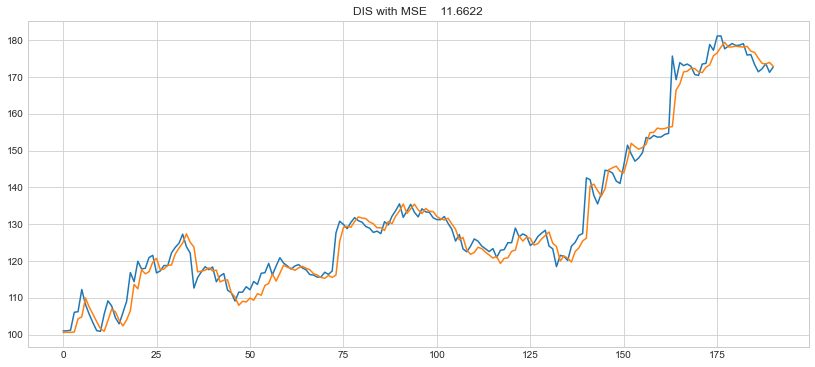

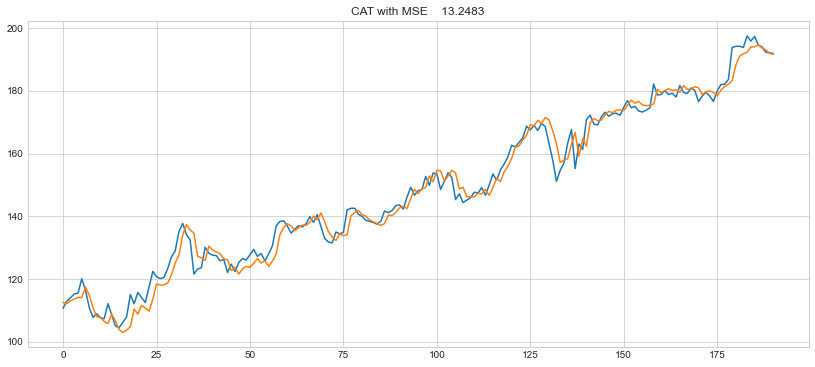

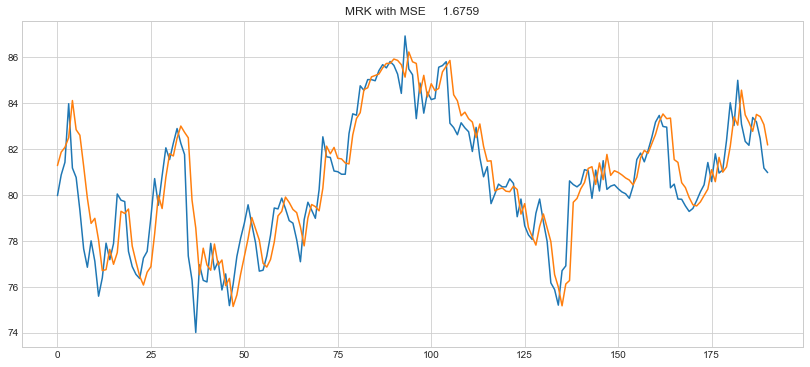

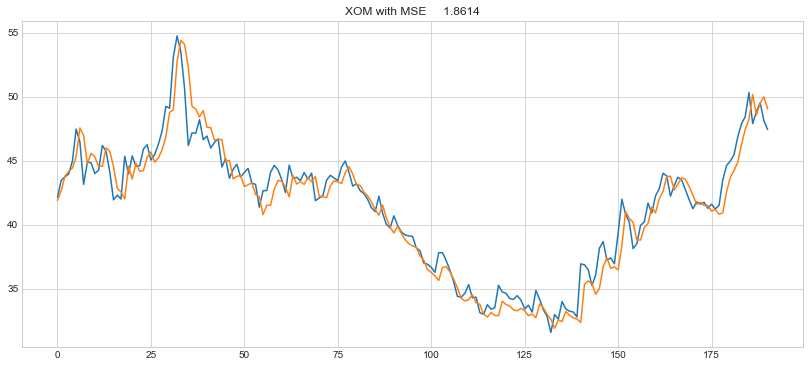

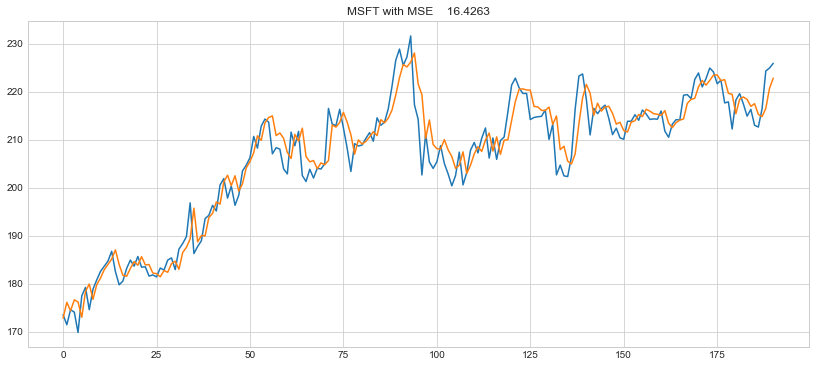

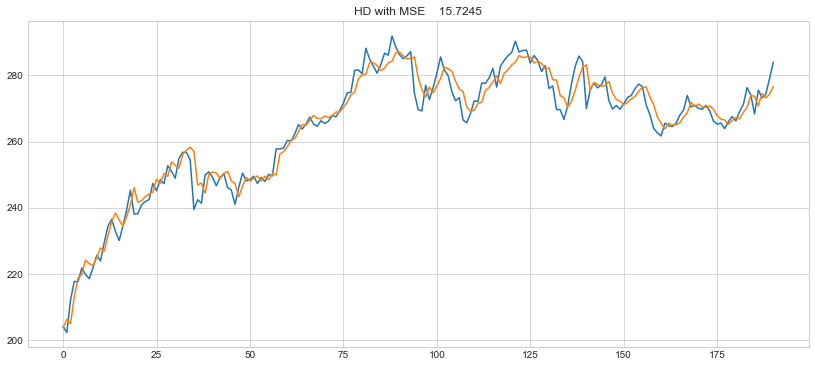

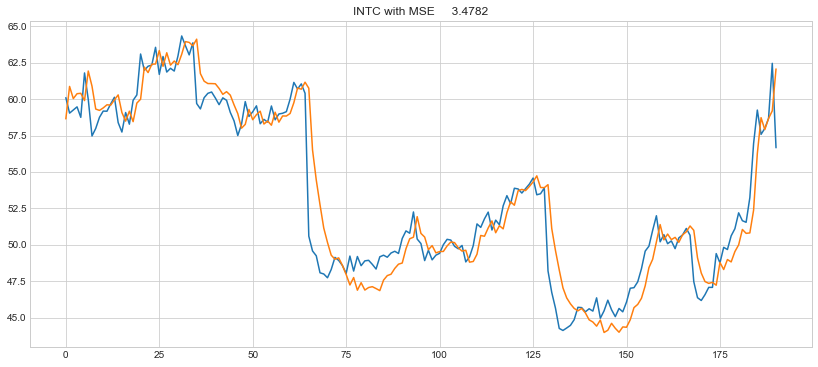

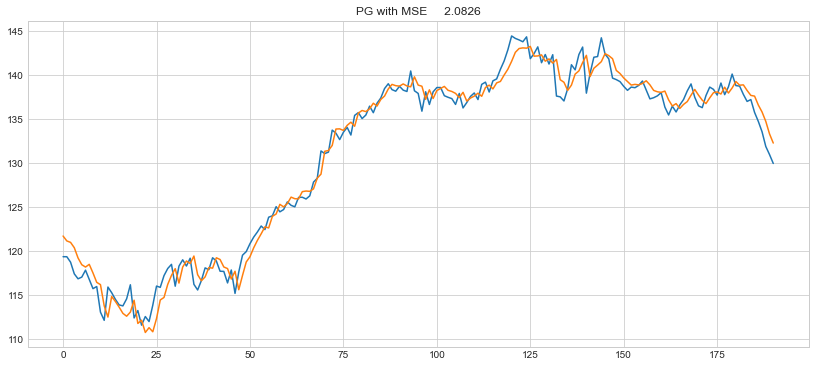

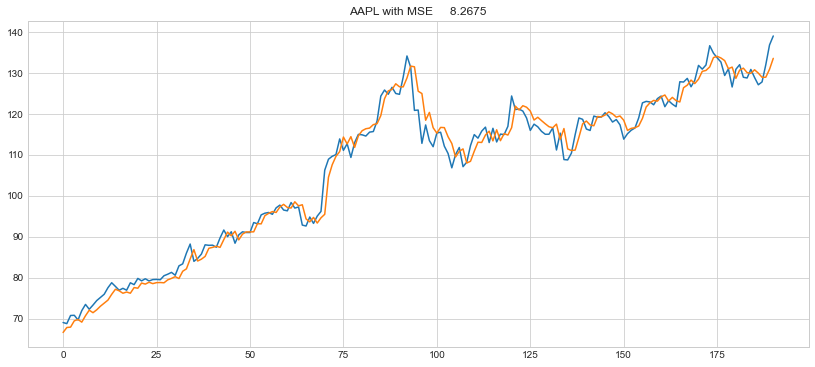

In [146]:
pred_new_result = {}
for stock in stockList:
    y_true_new = scaler_pred[stock].inverse_transform(predset[stock]["y"].reshape(-1,1))
    y_pred_new = scaler_pred[stock].inverse_transform(regressor.predict(predset[stock]["X"]))
    MSE = mean_squared_error(y_true_new, y_pred_new)
    #print(y_true)
    pred_new_result[stock] = {}
    pred_new_result[stock]["True"] = y_true_new
    pred_new_result[stock]["Pred"] = y_pred_new
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(stock,MSE))
    plt.plot(y_true_new)
    plt.plot(y_pred_new)

In [154]:
regressor.save("model/regressorLSTM_model.h5")

In [232]:

for stock in stockList:
    time_index = df_pred[stock]["Pred"][60:].index
    df_true_new, df_pred_new, df_pred_lag_new = lagging(pred_new_result[stock], -1, time_index)

    stockArr = []
    for i in range (0, len(df_true_new) ) :
        stockArr.append(stock)
    pred_output_LSTM = pd.DataFrame();
 
    pred_output_LSTM["Actual"] = df_true_new
    pred_output_LSTM["pred"] = df_pred_new
    pred_output_LSTM["PredLag"] = df_pred_lag_new
    pred_output_LSTM["stock"] = stockArr
    pred_output_LSTM["Date"] = df_true_new.index
    
    pred_output_LSTM.to_csv(f"output/output/LSTM_All_{stock}.csv", index = False)

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version